In [1]:
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from coffea.analysis_tools import PackedSelection
import awkward as ak
import os
import logging
import shutil
import hist
import json
import numpy as np
from coffea.lumi_tools import LumiMask
from coffea import processor
from Snip_debug import *
import crossSections
from coffea import util
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
    class Loadfileset():
        def __init__(self, jsonfilename) :
            with open(jsonfilename) as f :
                self.handler = json.load(f)
    
        
        def Show(self , verbosity=1):
            if verbosity==1 :
                for key, value in self.handler.items() :
                        rich.print(key+" : ", list(value.keys()))
            elif verbosity==2 :
                for key, value in self.handler.items() :
                        rich.print(key+" : ", list(value.keys()), "\n")
                        for subkey , subvalue in value.items() :
                            rich.print("\t"+subkey+" : ")
                            for file in subvalue :
                                rich.print("\t", file)
            elif verbosity==3 :
                for key, value in self.handler.items() :
                        rich.print(key+" : ", list(value.keys()), "\n")
                        for subkey , subvalue in value.items() :
                            rich.print("\t"+subkey+" : ")
                            for subsubkey, subsubvalue in subvalue.items() :
                                try :
                                    for file in subvalue :
                                        rich.print("\t", file)
                                except:
                                    rich.print("\t"+subsubkey+" : ")
        
        def getFileset(self, mode ,superkey, key, redirector ) :
            if redirector=="fnal":
                redirector_string = "root://cmsxrootd.fnal.gov//"
            elif redirector=="infn":
                redirector_string = "root://xrootd-cms.infn.it//"
            elif redirector=="wisc":
                redirector_string = "root://pubxrootd.hep.wisc.edu//"
            elif redirector=="unl":
                redirector_string = "root://xrootd-local.unl.edu:1094//"
            elif redirector=="kisti":
                redirector_string = "root://cms-xrdr.sdfarm.kr:1094//xrd//"
            raw_fileset = self.handler[mode][superkey][key] 
            requested_fileset = {superkey : [redirector_string+filename for filename in raw_fileset]}
            return requested_fileset
        
        def getraw(self):
            #load the raw dictionary
            full_fileset = self.handler
            return full_fileset
def getDataset(keymap, load=True, dict = None, files=None, begin=0, end=0, mode = "sequential"):
        #Warning : Never use 'files' with 'begin' and 'end'
        fileset = Loadfileset("MonoHiggstobb/Debug/control/newfileset.json")
        fileset_dict = fileset.getraw()
        MCmaps = [
            "MET_Run2018",
            "ZJets_NuNu",
            "TTToSemiLeptonic",
            "TTTo2L2Nu",
    	"TTToHadronic",
            "WJets_LNu",
            "DYJets_LL",
            "VV",
            "QCD",
            "ST"
            ]
    
        
        runnerfileset = buildFileset(fileset_dict[keymap],"commonfs")
        flat_list={}
        flat_list[keymap] = []
    
        if mode == "sequential":
            if end - begin <= 0:
                print("Invalid begin and end values.\nFalling back to full dataset...")
                outputfileset = runnerfileset
            else:
                # for key in runnerfileset.keys() :
                #     flat_list[keymap] += runnerfileset[key]
                #indexer
                index={}
                i = 1
                for key in runnerfileset.keys() :
                    index[key] = []
                    for file in runnerfileset[key] :
                        index[key].append(i)
                        i += 1
    
                accept = np.arange(begin,end+1,1)
                print(accept)
                temp = {}
                for key in runnerfileset.keys() :
                    temp[key] = []
                    for i in range(len(runnerfileset[key])) :
                        if index[key][i] in accept :
                            temp[key].append(runnerfileset[key][i])
                #outputfileset = {keymap : flat_list[keymap][(begin - 1) :end]}
                #outputfileset = {keymap : temp}
                outputfileset = temp
        elif mode == "divide" :
            if files == None:
                print("Invalid number of files.\nFalling back to full dataset...")
                outputfileset = runnerfileset
            else:
                # Divide the share of files from all the 8 categories of ZJets_NuNu
                file_number = 0
                while file_number < files :
                    for key in runnerfileset.keys():
                        if file_number >= files :
                            break
                        flat_list[keymap] += [runnerfileset[key][0]]
                        runnerfileset[key] = runnerfileset[key][1:]
                        file_number += 1
                outputfileset = {keymap : flat_list[keymap]}
        else:
            print("Invalid mode of operation", mode)
            raise KeyError
        
        print("Running ", np.array([len(value) for value in outputfileset.values()]).sum(), " files...")
        return outputfileset
def buildFileset(dict , redirector):
        '''
        To return a run-able dict with the appropriate redirector.
        Please input a dictionary which is only singly-nested
        '''
        redirectors = {
            "fnal": "root://cmsxrootd.fnal.gov//",
            "infn": "root://xrootd-cms.infn.it//",
            "wisc": "root://pubxrootd.hep.wisc.edu//",
            "unl":  "root://xrootd-local.unl.edu:1094/",
            "kisti": "root://cms-xrdr.sdfarm.kr:1094//xrd/",
            "hdfs": "/hdfs",
            "commonfs": "/commonfs"
    
        }
    
        if (redirector=="fnal") | (redirector==1) :
            redirector_string = redirectors["fnal"]
        elif (redirector=="infn") | (redirector==2) :
            redirector_string = redirectors["infn"]
        elif (redirector=="wisc") | (redirector==3):
            redirector_string = redirectors["wisc"]
        elif (redirector=="unl") | (redirector==4):
            redirector_string = redirectors["unl"]
        elif (redirector=="kisti") | (redirector==5):
            redirector_string = redirectors["kisti"]
        elif (redirector=="hdfs") | (redirector==6):
            redirector_string = redirectors["hdfs"]
        elif (redirector=="commonfs") | (redirector==7):
            redirector_string = redirectors["commonfs"]
    
        temp = dict 
        output = {}
        for key in temp.keys() :
            try :
                g = temp[key]
                if isinstance(g,list):
                    templist = []
                    for filename in g :
                        filename = filename[filename.find("/store/") :]
                        templist.append(redirector_string+filename)
                    output[key] = templist
            except :
                raise KeyError
        return output

In [4]:
def get_lumiobject():
    path = "Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt" 
    return LumiMask(path)

lumimaskobject = get_lumiobject()

def lumi(events,cutflow,path="",lumiobject=None):
    #Selecting use-able events
    if lumiobject==None :
        #path_of_file = path+"Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.json"
        path_of_file = path+"golden.json"
        lumimask = LumiMask(path_of_file)
    else :
        lumimask = lumiobject
    events = events[lumimask(events.run, events.luminosityBlock)]
    cutflow["lumimask"] = len(events)
    return events , cutflow

In [5]:

#Begin the processor definition
class Top_mu(processor.ProcessorABC):
    """
    Flow of Data:

    INPUT EVENTS
        |
        |-------------------------------------------
        |                                           |
        |                                           |
        v                                           v
        if MET_Run2018                        else if MC
        |                                           |
        |                                           |
        |                                           |
        v                                           |
    MET TRIGGER                                     |
        |                                           |
        |                                           |
        |                                           |
        v                                           |
    MET FILTERS                                     |
        |                                           |
        |<------------------------------------------
        |                                           
        v
    MET CUT
        |
        |
        |
        v
    EVENT SELECTION AND OBJECT SELECTION
        |
        |
        |
        v
    Make MET pt eta phi, DIJET mass etc plots - all of them plots
    """


    def __init__(self,category,helper_objects = [] ):
        # Initialize the cutflow dictionary
        if len(helper_objects) > 0 :
            self.lumiobject = helper_objects[0] 
        self.category = category
        self.cutflow = {}
        self.run_set = set({})

    def process(self, events):
        # process everything according to their recoil window
        def process_by_recoil_window(self,events,recoil_window):
            dataset = events.metadata["dataset"]
            self.mode = dataset
            self.recoil_window , self.mass_nbin = recoil_window 
            cutflow = {}
            cutflow["Total events"] = len(events) #Total Number of events

            #Preparing histogram objects
            #MET
            met_pt_min = 0
            met_pt_max = 500
            met_pt_nbins = 25
            met_pt_hist = (
                hist.
                Hist.
                new.
                Reg(met_pt_nbins,met_pt_min,met_pt_max).
                Double()
            )
            met_phi_min = -3.14
            met_phi_max = 3.14
            met_phi_nbins = 6
            met_phi_hist = (
                hist.
                Hist.
                new.
                Reg(met_phi_nbins,met_phi_min,met_phi_max).
                Double()
            )
            #Leading ak4bjets
            leadingjets_pt_min = 0
            leadingjets_pt_max = 500
            leadingjets_pt_nbins = 25
            leadingjets_pt_hist = (
                hist.
                Hist.
                new.
                Reg(leadingjets_pt_nbins,leadingjets_pt_min,leadingjets_pt_max).
                Double()
            )
            leadingjets_eta_min = -2.5
            leadingjets_eta_max = 2.5
            leadingjets_eta_nbins = 5
            leadingjets_eta_hist = (
                hist.
                Hist.
                new.
                Reg(leadingjets_eta_nbins,leadingjets_eta_min,leadingjets_eta_max).
                Double()
            )
            leadingjets_phi_min = -3.14
            leadingjets_phi_max = 3.14
            leadingjets_phi_nbins = 6
            leadingjets_phi_hist = (
                hist.
                Hist.
                new.
                Reg(leadingjets_phi_nbins,leadingjets_phi_min,leadingjets_phi_max).
                Double()
            )
            leadingjets_mass_min = 0
            leadingjets_mass_max = 300
            leadingjets_mass_nbins = self.mass_nbin
            leadingjets_mass_hist = (
                hist.
                Hist.
                new.
                Reg(leadingjets_mass_nbins,leadingjets_mass_min,leadingjets_mass_max).
                Double()
            )
            #Subleading ak4 bjets
            subleadingjets_pt_min = 0
            subleadingjets_pt_max = 500
            subleadingjets_pt_nbins = 25
            subleadingjets_pt_hist = (
                hist.
                Hist.
                new.
                Reg(subleadingjets_pt_nbins,subleadingjets_pt_min,subleadingjets_pt_max).
                Double()
            )
            subleadingjets_eta_min = -2.5
            subleadingjets_eta_max = 2.5
            subleadingjets_eta_nbins = 5
            subleadingjets_eta_hist = (
                hist.
                Hist.
                new.
                Reg(subleadingjets_eta_nbins,subleadingjets_eta_min,subleadingjets_eta_max).
                Double()
            )
            subleadingjets_phi_min = -3.14
            subleadingjets_phi_max = 3.14
            subleadingjets_phi_nbins = 6
            subleadingjets_phi_hist = (
                hist.
                Hist.
                new.
                Reg(subleadingjets_phi_nbins,subleadingjets_phi_min,subleadingjets_phi_max).
                Double()
            )
            subleadingjets_mass_min = 0
            subleadingjets_mass_max = 300
            subleadingjets_mass_nbins = self.mass_nbin
            subleadingjets_mass_hist = (
                hist.
                Hist.
                new.
                Reg(subleadingjets_mass_nbins,subleadingjets_mass_min,subleadingjets_mass_max).
                Double()
            )
            #ak4bjet-ak4bjet dijets 
            dijets_pt_min = 0
            dijets_pt_max = 500
            dijets_pt_nbins = 25
            dijets_pt_hist = (
                hist.
                Hist.
                new.
                Reg(dijets_pt_nbins,dijets_pt_min,dijets_pt_max).
                Double()
                )
            dijets_eta_min = -2.5
            dijets_eta_max = 2.5
            dijets_eta_nbins = 5
            dijets_eta_hist = (
                hist.
                Hist.
                new.
                Reg(dijets_eta_nbins,dijets_eta_min,dijets_eta_max).
                Double()
                )
            dijets_phi_min = -3.14
            dijets_phi_max = 3.14
            dijets_phi_nbins = 6
            dijets_phi_hist = (
                hist.
                Hist.
                new.
                Reg(dijets_phi_nbins,dijets_phi_min,dijets_phi_max).
                Double()
                )
            dijets_mass_min = 100
            dijets_mass_max = 150
            dijets_mass_nbins = self.mass_nbin
            dijets_mass_hist = (
                hist.
                Hist.
                new.
                Reg(dijets_mass_nbins,dijets_mass_min,dijets_mass_max).
                Double()
                )

            if (self.mode).startswith("MET") :

                #choosing certified good events
                should_lumi = False
                if should_lumi :
                    events, cutflow = lumi(events, cutflow, lumiobject=self.lumiobject)

                #Saving the event run
                for run in set(events.run):
                    self.run_set.add(run)

                #MET_Trigger
                events, cutflow = met_trigger(events,cutflow,era=2018)

                #MET_Filters
                events, cutflow = met_filter(events,cutflow)
            

            #vetoes
            events, cutflow = no_electrons(events,cutflow)
            if (self.mode).startswith("MonoHTobb_ZpBaryonic"):
                events, cutflow = no_taus(events,cutflow, version=7)
            else :
                events, cutflow = no_taus(events,cutflow, version=9)
            events, cutflow = no_photons(events,cutflow)

            #HEM veto
            events,cutflow = HEM_veto_bril(events,cutflow)

            #Object selections
                
            #Exactly one tight muon
            events, single_muons, cutflow = tight_muons(events,cutflow)

            #MET_selection
            events, cutflow = met_selection(events,cutflow,GeV=50.0)

            dummy_dict = {}
            dummy_events, single_muons, dummy_dict = tight_muons(events,dummy_dict) # I just want to get tight muons back, so I use the same function with some dummy variables

            #Hadronic Recoil
            #There is at least one muon(tight) in each event at this point
            #events.Recoil = events.MET.pt + ak.flatten(single_muons.pt)
            # if self.category == "boosted" :
            #     recoil = 250.0
            # elif self.category == "resolved" :
            #     recoil = 200.0
            Recoil = get_recoil(events,single_muons)
            windowcut = (Recoil > self.recoil_window[0]) & (Recoil < self.recoil_window[1])
            events = events[windowcut]
            cutflow["Recoil"] = len(events)

            #Do the calculations
            wp = get_wp(Era=2018,wp="medium")
            is_bjet = events.Jet.btagDeepFlavB > wp
            bjets = events.Jet[is_bjet]
            
            at_least_two_such_jets = ak.num(bjets, axis=1) >= 2
            bjets = bjets[at_least_two_such_jets]
            
            leading_bjets = bjets[:,0]
            leading_jet_pt_at_least_50 = leading_bjets.pt > 50
            bjets = bjets[leading_jet_pt_at_least_50 ]
            
            subleading_bjets = bjets[:,1]
            subleading_jet_pt_at_least_30 = subleading_bjets.pt > 30
            bjets = bjets[subleading_jet_pt_at_least_30]
            
            dijets = bjets[:,0]+bjets[:,1]

            dijets_pt_selection = dijets.pt > 100
            dijets = dijets[dijets_pt_selection]
            
            dijets_mass_window = (dijets.mass < 150) & (dijets.mass > 70)
            dijets = dijets[dijets_mass_window]
            
            #Reobtain the leading and subleading jets after the dijet cuts
            leadingjets = bjets[:,0]
            leadingjets = leadingjets[dijets_pt_selection]
            leadingjets = leadingjets[dijets_mass_window]

            subleadingjets = bjets[:,1]
            subleadingjets = subleadingjets[dijets_pt_selection]
            subleadingjets = subleadingjets[dijets_mass_window]

            #Updating the cutflow for all the above processes
            events = events[at_least_two_such_jets]
            
            events = events[leading_jet_pt_at_least_50]
            cutflow["leading jet pt > 50"] = len(events)
            
            events = events[subleading_jet_pt_at_least_30]
            cutflow["subleading jet pt > 30"] = len(events)

            events = events[dijets_pt_selection]
            cutflow["pt(bb) > 100"] = len(events)
            
            events = events[dijets_mass_window]
            cutflow["70 < M_bb < 150"] = len(events)

            one_normal_additional_jet = ak.num(events.Jet) >= 3
            events = events[one_normal_additional_jet]
            pt_greater_than30 = events.Jet.pt[:,2] > 30
            acceptable_eta = abs(events.Jet.eta[:,2] ) < 2.5
            events = events[pt_greater_than30 & acceptable_eta]
            cutflow["At least one normal additional jet"] = len(events)

            #Fill the histogram
            #MET
            met_pt_hist.fill(events.MET.pt)
            met_phi_hist.fill(events.MET.phi)

            if self.category == 'resolved':
                #Leading jets
                leadingjets_pt_hist.fill(leadingjets.pt)
                leadingjets_eta_hist.fill(leadingjets.eta)
                leadingjets_phi_hist.fill(leadingjets.phi)
                leadingjets_mass_hist.fill(leadingjets.mass)
                #Subleading jets
                subleadingjets_pt_hist.fill(subleadingjets.pt)
                subleadingjets_eta_hist.fill(subleadingjets.eta)
                subleadingjets_phi_hist.fill(subleadingjets.phi)
                subleadingjets_mass_hist.fill(subleadingjets.mass)
                #ak4bjet-ak4bjet dijets
                dijets_pt_hist.fill(dijets.pt)
                dijets_eta_hist.fill(dijets.eta)
                dijets_phi_hist.fill(dijets.phi)
                dijets_mass_hist.fill(dijets.mass)
            elif self.category == 'boosted':
                
        

            #Prepare the output
            key_list = [
            "MET_Run2018",
            "ZJets_NuNu",
            "TTToSemiLeptonic",
            "TTTo2L2Nu",
            "TTToHadronic",
            "WJets_LNu",
            "DYJets_LL",
            "VV",
            "QCD",
            "ST"
            ]
            if self.mode.startswith("MET_Run2018") :
                self.key = key_list[0]
            elif "Jets_NuNu" in self.mode :
                self.key = key_list[1]
            elif self.mode.startswith("TTToSemiLeptonic"):
                self.key = key_list[2]
            elif self.mode.startswith("TTTo2L2Nu"):
                self.key = key_list[3]
            elif self.mode.startswith("TTToHadronic"):
                self.key = key_list[4]
            elif self.mode.startswith("WJets_LNu"):
                self.key = key_list[5]
            elif self.mode.startswith("DYJets_LL"):
                self.key = key_list[6]
            elif ( self.mode.startswith("WW") | self.mode.startswith("WZ") | self.mode.startswith("ZZ") ) :
                self.key = key_list[7]
            elif self.mode.startswith("QCD"):
                self.key = key_list[8]
            elif self.mode.startswith("ST"):
                self.key = key_list[9]
            else :
                print("Unidentified dataset ", self.mode)
                raise KeyError
        
            #Saving the output 
            if self.category == 'resolved':
                output_by_recoil_window = {
                    self.key : {
                        self.mode : {
                            "Cutflow": cutflow ,
                            "Histograms": {
                                "met_pt_hist" : met_pt_hist ,
                                "met_phi_hist" : met_phi_hist ,
                                "leadingjets_pt_hist" : leadingjets_pt_hist ,
                                "leadingjets_eta_hist" : leadingjets_eta_hist ,
                                "leadingjets_phi_hist" : leadingjets_phi_hist ,
                                "leadingjets_mass_hist" : leadingjets_mass_hist ,
                                "subleadingjets_pt_hist" : subleadingjets_pt_hist ,
                                "subleadingjets_eta_hist" : subleadingjets_eta_hist ,
                                "subleadingjets_phi_hist" : subleadingjets_phi_hist ,
                                "subleadingjets_mass_hist" : subleadingjets_mass_hist ,
                                "dijets_pt" : dijets_pt_hist ,
                                "dijets_eta" : dijets_eta_hist ,
                                "dijets_phi" : dijets_phi_hist ,
                                "dijets_mass" : dijets_mass_hist ,
                                },
                            "RunSet":self.run_set
                            }
                        }
                    }
            elif self.category == 'resolved':
                output_by_recoil_window = {
                    self.key : {
                        self.mode : {
                            "Cutflow": cutflow ,
                            "Histograms": {
                                "met_pt_hist" : met_pt_hist ,
                                "met_phi_hist" : met_phi_hist ,
                                },
                            "RunSet":self.run_set
                            }
                        }
                    }
            return output_by_recoil_window
        
        ##########################################################################
        #Implementing the different regions
        # recoil in (mass_range , bins) format
        if self.category == 'resolved':
            recoils = {
                1: ([200,250],18),
                2: ([250,290],11),
                3: ([290,360],8),
                4: ([360,420],4),
                5: ([420,1000],3)
            }
            output = {}
            output["Recoil:200-250"] = process_by_recoil_window(self,events,recoils[1])
            output["Recoil:250-290"] = process_by_recoil_window(self,events,recoils[2])
            output["Recoil:290-360"] = process_by_recoil_window(self,events,recoils[3])
            output["Recoil:360-420"] = process_by_recoil_window(self,events,recoils[4])
            output["Recoil:420-1000"] = process_by_recoil_window(self,events,recoils[5])
        elif self.category == 'boosted':
            recoils = {
                1: ([250,350],12),
                2: ([350,500],10),
                3: ([500,1000],3),
            }
            output = {}
            output["Recoil:250-350"] = process_by_recoil_window(self,events,recoils[1])
            output["Recoil:350-500"] = process_by_recoil_window(self,events,recoils[2])
            output["Recoil:500-1000"] = process_by_recoil_window(self,events,recoils[3])
        return output

    def postprocess(self, accumulator):
        pass


In [6]:
def adder(raw_dict , onlydata = False):
    """
    Adds(accumulates) the dictionaries from subcategories using cross section in case of MCs or raw in case of data 
    """
    if onlydata == False:
        raw_dict = xsec_reweight(raw_dict) #Return the same dict with cross section reweighting applied to MCs
    output_dict = {}
    keys = list(raw_dict.keys())
    for key in keys :
        subkeys = list(raw_dict[key].keys())
        temp = []
        for subkey in subkeys :
            temp.append(raw_dict[key][subkey])
        output_dict[key] = processor.accumulate(temp)
    return output_dict

def xsec_reweight(input_dict):
    """
    Returns the same histogram with cross section reweighting applied to every MC histogram object and cutflow dictionary
    """
    lumi = crossSections.lumis[2018]
    #print("Integrated Luminosity(pb): ", lumi)

    #load cross sections

    ZJets_NuNu_xsec = {
        "Z1Jets_NuNu_ZpT_50To150_18": crossSections.crossSections["Z1Jets_NuNu_ZpT_50To150_18"],
        "Z1Jets_NuNu_ZpT_150To250_18": crossSections.crossSections["Z1Jets_NuNu_ZpT_150To250_18"],
        "Z1Jets_NuNu_ZpT_250To400_18": crossSections.crossSections["Z1Jets_NuNu_ZpT_250To400_18"],
        "Z1Jets_NuNu_ZpT_400Toinf_18": crossSections.crossSections["Z1Jets_NuNu_ZpT_400Toinf_18"],
        "Z2Jets_NuNu_ZpT_50To150_18": crossSections.crossSections["Z2Jets_NuNu_ZpT_50To150_18"],
        "Z2Jets_NuNu_ZpT_150To250_18": crossSections.crossSections["Z2Jets_NuNu_ZpT_150To250_18"],
        "Z2Jets_NuNu_ZpT_250To400_18": crossSections.crossSections["Z2Jets_NuNu_ZpT_250To400_18"],
        "Z2Jets_NuNu_ZpT_400Toinf_18": crossSections.crossSections["Z2Jets_NuNu_ZpT_400Toinf_18"]
    }

    TTToSemiLeptonic_xsec = {
        "TTToSemiLeptonic_18":crossSections.crossSections["TTToSemiLeptonic_18"]
    }
    
    TTTo2L2Nu_xsec = {
        "TTTo2L2Nu_18": crossSections.crossSections["TTTo2L2Nu_18"]
    }
    
    TTToHadronic_xsec = {
        "TTToHadronic_18": crossSections.crossSections["TTToHadronic_18"]
    }

    WJets_LNu_xsec = {
        "WJets_LNu_WPt_100To250_18": crossSections.crossSections["WJets_LNu_WPt_100To250_18"],
        "WJets_LNu_WPt_250To400_18": crossSections.crossSections["WJets_LNu_WPt_250To400_18"],
        "WJets_LNu_WPt_400To600_18": crossSections.crossSections["WJets_LNu_WPt_400To600_18"],
        "WJets_LNu_WPt_600Toinf_18": crossSections.crossSections["WJets_LNu_WPt_600Toinf_18"],
    }

    DYJets_LL_xsec = {
        "DYJets_LL_Pt_0To50_18": crossSections.crossSections["DYJets_LL_Pt_0To50_18"],
        "DYJets_LL_Pt_50To100_18": crossSections.crossSections["DYJets_LL_Pt_50To100_18"],
        "DYJets_LL_Pt_100To250_18": crossSections.crossSections["DYJets_LL_Pt_100To250_18"],
        "DYJets_LL_Pt_250To400_18": crossSections.crossSections["DYJets_LL_Pt_250To400_18"],
        "DYJets_LL_Pt_400To650_18": crossSections.crossSections["DYJets_LL_Pt_400To650_18"],
        "DYJets_LL_Pt_650Toinf_18": crossSections.crossSections["DYJets_LL_Pt_650Toinf_18"],
    }

    VV_xsec = {
        "WZ_1L1Nu2Q_18": crossSections.crossSections["WZ_1L1Nu2Q_18"],
        "WZ_2L2Q_18": crossSections.crossSections["WZ_2L2Q_18"],
        #"WZ_2Q2Nu_18": crossSections.crossSections["WZ_2Q2Nu_18"],
        "WZ_3L1Nu_18" : crossSections.crossSections["WZ_3L1Nu_18"],
        "ZZ_2L2Nu_18": crossSections.crossSections["ZZ_2L2Nu_18"],
        "ZZ_2L2Q_18": crossSections.crossSections["ZZ_2L2Q_18"],
        "ZZ_2Q2Nu_18": crossSections.crossSections["ZZ_2Q2Nu_18"],
        "ZZ_4L_18": crossSections.crossSections["ZZ_4L_18"],
        "WW_2L2Nu_18": crossSections.crossSections["WW_2L2Nu_18"],
        "WW_1L1Nu2Q_18": crossSections.crossSections["WW_1L1Nu2Q_18"],
    }

    QCD_xsec = {
        #"QCD_HT100To200_18": crossSections.crossSections["QCD_HT100To200_18"],
        "QCD_HT200To300_18": crossSections.crossSections["QCD_HT200To300_18"],
        "QCD_HT300To500_18": crossSections.crossSections["QCD_HT300To500_18"],
        "QCD_HT500To700_18": crossSections.crossSections["QCD_HT500To700_18"],
        "QCD_HT700To1000_18": crossSections.crossSections["QCD_HT700To1000_18"],
        "QCD_HT1000To1500_18": crossSections.crossSections["QCD_HT1000To1500_18"],
        "QCD_HT1500To2000_18": crossSections.crossSections["QCD_HT1500To2000_18"],
        "QCD_HT2000Toinf_18": crossSections.crossSections["QCD_HT2000Toinf_18"],
    }

    ST_xsec = {
        "ST_tchannel_top_18": crossSections.crossSections["ST_tchannel_top_18"],
        "ST_tchannel_antitop_18": crossSections.crossSections["ST_tchannel_antitop_18"],
        "ST_tW_top_18": crossSections.crossSections["ST_tW_top_18"],
        "ST_tW_antitop_18": crossSections.crossSections["ST_tW_antitop_18"]
    }

    #compute weight_factor for ZJets_NuNu 
    N_i = {}
    ZJets_NuNu_weight_factor = {}
    for subkey in ZJets_NuNu_xsec.keys() :
        N_i[subkey] = input_dict["ZJets_NuNu"][subkey]["Cutflow"]["Total events"]
        ZJets_NuNu_weight_factor[subkey] = ( lumi * ZJets_NuNu_xsec[subkey] )/N_i[subkey]

    #compute weight_factor for TTToSemiLeptonic
    N_i = {}
    TTToSemiLeptonic_weight_factor = {}
    for subkey in TTToSemiLeptonic_xsec.keys() :
        N_i[subkey] = input_dict["TTToSemiLeptonic"][subkey]["Cutflow"]["Total events"]
        TTToSemiLeptonic_weight_factor[subkey] = ( lumi * TTToSemiLeptonic_xsec[subkey] )/N_i[subkey]

    #compute weight_factor for TTTo2L2Nu
    N_i = {}
    TTTo2L2Nu_weight_factor = {}
    for subkey in TTTo2L2Nu_xsec.keys() :
        N_i[subkey] = input_dict["TTTo2L2Nu"][subkey]["Cutflow"]["Total events"]
        TTTo2L2Nu_weight_factor[subkey] = ( lumi * TTTo2L2Nu_xsec[subkey] )/N_i[subkey]

    #compute weight_factor for TTToHadronic
    N_i = {}
    TTToHadronic_weight_factor = {}
    for subkey in TTToHadronic_xsec.keys() :
        N_i[subkey] = input_dict["TTToHadronic"][subkey]["Cutflow"]["Total events"]
        TTToHadronic_weight_factor[subkey] = ( lumi * TTToHadronic_xsec[subkey] )/N_i[subkey]

    #compute weight_factor for WJets_LNu
    N_i = {}
    WJets_LNu_weight_factor = {}
    for subkey in WJets_LNu_xsec.keys() :
        N_i[subkey] = input_dict["WJets_LNu"][subkey]["Cutflow"]["Total events"]
        WJets_LNu_weight_factor[subkey] = ( lumi * WJets_LNu_xsec[subkey] )/N_i[subkey]

    #compute weight_factor for DYJets_LL
    N_i = {}
    DYJets_LL_weight_factor = {}
    for subkey in DYJets_LL_xsec.keys() :
        N_i[subkey] = input_dict["DYJets_LL"][subkey]["Cutflow"]["Total events"]
        DYJets_LL_weight_factor[subkey] = ( lumi * DYJets_LL_xsec[subkey] )/N_i[subkey]

    #compute weight_factor for VV
    N_i = {}
    VV_weight_factor = {}
    for subkey in VV_xsec.keys() :
        N_i[subkey] = input_dict["VV"][subkey]["Cutflow"]["Total events"]
        VV_weight_factor[subkey] = ( lumi * VV_xsec[subkey] )/N_i[subkey]

    #compute weight_factor for QCD
    N_i = {}
    QCD_weight_factor = {}
    for subkey in QCD_xsec.keys() :
        N_i[subkey] = input_dict["QCD"][subkey]["Cutflow"]["Total events"]
        QCD_weight_factor[subkey] = ( lumi * QCD_xsec[subkey] )/N_i[subkey]

    #compute weight_factor for ST
    N_i = {}
    ST_weight_factor = {}
    for subkey in ST_xsec.keys() :
        N_i[subkey] = input_dict["ST"][subkey]["Cutflow"]["Total events"]
        ST_weight_factor[subkey] = ( lumi * ST_xsec[subkey] )/N_i[subkey]

    #individually apply cross section
    def hist_xsec(MC_dict, key_weight_factor):
        keys = list(MC_dict.keys())
        
        for key in keys:
            #Reweight the all the cutflow events
            cutflow_keys = list(MC_dict[key]["Cutflow"].keys())
            for cutflow_key in cutflow_keys :
                MC_dict[key]["Cutflow"][cutflow_key] *= key_weight_factor[key]
                
            # Reweight all the histograms
            properties = list(MC_dict[key]["Histograms"].keys())
            for property in properties:
                MC_dict[key]["Histograms"][property] *= key_weight_factor[key]
            #key_hists[key] *= key_weight_factor[key] #legacy
        return MC_dict

    
    input_dict["ZJets_NuNu"] = hist_xsec(input_dict["ZJets_NuNu"] , ZJets_NuNu_weight_factor)
    input_dict["TTToSemiLeptonic"] = hist_xsec(input_dict["TTToSemiLeptonic"], TTToSemiLeptonic_weight_factor)
    input_dict["TTTo2L2Nu"] = hist_xsec(input_dict["TTTo2L2Nu"], TTTo2L2Nu_weight_factor)
    input_dict["TTToHadronic"] = hist_xsec(input_dict["TTToHadronic"], TTToHadronic_weight_factor)
    input_dict["WJets_LNu"] = hist_xsec(input_dict["WJets_LNu"], WJets_LNu_weight_factor)
    input_dict["DYJets_LL"] = hist_xsec(input_dict["DYJets_LL"], DYJets_LL_weight_factor)
    input_dict["VV"] = hist_xsec(input_dict["VV"], VV_weight_factor)
    input_dict["QCD"] = hist_xsec(input_dict["QCD"], QCD_weight_factor)
    input_dict["ST"] = hist_xsec(input_dict["ST"], ST_weight_factor)

    return input_dict
def simpleoverallcutflow(master_dict,dataset="MET_Run2018"):
    temp = []
    nrecoil = 0
    for key in master_dict:
        nrecoil += 1
        added = adder(master_dict[key] , onlydata=True)
        cat_dict = added[dataset]["Cutflow"]
        temp.append(cat_dict)
    output_dict = processor.accumulate(temp)
    repeated_keys = ["Total events","MET trigger","MET filters","MET > 50.0 GeV","no electrons","no photons","no taus","HEM veto","one_tight_muon"]
    #repeated_keys = ["Total events","MET trigger","MET filters","MET > 50.0 GeV","no electrons","no photons","no taus","one_tight_muon"]
    #repeated_keys = ["Total events","MET trigger","MET filters","MET > 50.0 GeV","no photons","no taus","one_tight_muon"]
    for key in repeated_keys :
        output_dict[key] = output_dict[key] / nrecoil
    #convert values in scientific notation
    output_dict = {key : "{:e}".format(value) for key,value in output_dict.items()}
    return output_dict
def show(dict):
    for key in dict.keys() :
        print(key , " : ", dict[key] , " \n")

In [6]:
run_at = "dask"
beginat = 40
endat = 61
nworkers = 16
chunk_size = 500000
def zip_files(list_of_files):
        os.makedirs("temporary_folder")
        for file in list_of_files :
            shutil.copy(file,"temporary_folder")
        archive_name = "helper_files"
        shutil.make_archive(archive_name,"zip","temporary_folder")
        shutil.rmtree("temporary_folder")
        return archive_name+".zip"
#For futures execution
if run_at == "futures" :
    files = getDataset(keymap="MET_Run2018",load=True, mode="sequential", begin=beginat, end=endat)
    futures_run = processor.Runner(
        executor = processor.FuturesExecutor(workers=nworkers),
        schema=NanoAODSchema,
        chunksize=chunk_size ,
        xrootdtimeout=120
    )
    Output = futures_run(
        files,
        "Events",
        processor_instance=Top_mu(category="resolved",helper_objects=[lumimaskobject])
    )

#For dask execution
elif run_at == "dask" :
    from dask.distributed import Client , LocalCluster
    cluster = LocalCluster()
    client = Client(cluster)
    print("scheduler at ", client.scheduler.address)
    cluster.scale(nworkers)

    client.upload_file(zip_files(
        [
            "MonoHiggstobb/Debug/control/Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt",
            "MonoHiggstobb/Debug/control/Snip_debug.py"
            ]
        )
        )
    with open("MonoHiggstobb/Debug/control/newfileset.json") as f: #load the fileset
        filedict = json.load(f)
    files = getDataset(keymap="MET_Run2018",load=True, mode="sequential", begin=begin_at, end=end_at)
    dask_run = processor.Runner(
        executor = processor.DaskExecutor(client=client),
        schema=NanoAODSchema,
        chunksize= chunk_size
    )
    Output = dask_run(
        files,
        "Events",
        processor_instance=Top_mu(category="resolved",helper_objects=[lumimaskobject])
    )

scheduler at  tcp://127.0.0.1:39267
[40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
Running  22  files...


In [ ]:
try :
    output_file = f"CR_resolved_Top_MET_Run2018_from_beginat_to_endat.coffea"
    pass
except :
    output_file = f"CR_{inputs.cat}_Top_{inputs.keymap}.coffea"
print("Saving the output to : " , output_file)
util.save(output= Output, filename="coffea_files/"+output_file)
print(f"File {output_file} saved.")

In [7]:
for key in Output.keys():
    print(Output[key]['MET_Run2018']['MET_Run2018B']['Cutflow'])


{'Total events': 29713483, 'MET trigger': 14989175, 'MET filters': 13794262, 'no electrons': 13572445, 'no taus': 13463780, 'no photons': 13348174, 'HEM veto': 13339244, 'one_tight_muon': 489807, 'MET > 50.0 GeV': 387633, 'Recoil': 104093, 'leading jet pt > 50': 12562, 'subleading jet pt > 30': 9159, 'pt(bb) > 100': 5701, '70 < M_bb < 150': 1654, 'At least one normal additional jet': 1565}
{'Total events': 29713483, 'MET trigger': 14989175, 'MET filters': 13794262, 'no electrons': 13572445, 'no taus': 13463780, 'no photons': 13348174, 'HEM veto': 13339244, 'one_tight_muon': 489807, 'MET > 50.0 GeV': 387633, 'Recoil': 39682, 'leading jet pt > 50': 5036, 'subleading jet pt > 30': 3712, 'pt(bb) > 100': 2483, '70 < M_bb < 150': 650, 'At least one normal additional jet': 622}
{'Total events': 29713483, 'MET trigger': 14989175, 'MET filters': 13794262, 'no electrons': 13572445, 'no taus': 13463780, 'no photons': 13348174, 'HEM veto': 13339244, 'one_tight_muon': 489807, 'MET > 50.0 GeV': 3876

In [8]:
show(simpleoverallcutflow(Output))

Total events  :  2.971348e+07  

MET trigger  :  1.498918e+07  

MET filters  :  1.379426e+07  

no electrons  :  1.357244e+07  

no taus  :  1.346378e+07  

no photons  :  1.334817e+07  

HEM veto  :  1.333924e+07  

one_tight_muon  :  4.898070e+05  

MET > 50.0 GeV  :  3.876330e+05  

Recoil  :  1.914800e+05  

leading jet pt > 50  :  2.366000e+04  

subleading jet pt > 30  :  1.740800e+04  

pt(bb) > 100  :  1.153100e+04  

70 < M_bb < 150  :  3.060000e+03  

At least one normal additional jet  :  2.913000e+03  



In [34]:
def accum(key):
    path = "coffea_files/debug/"
    list_files = os.listdir(path)
    valid_list = []
    for file in list_files :
        if file.startswith(f"CR_resolved_Top_{key}_from") :
            valid_list.append(file)
    full = processor.accumulate([util.load(path+name) for name in valid_list])
    return full
    
def plot_CR(input_dict,property="dijets_mass"):
    recoil_windows = list(input_dict.keys())
    labels = ["Recoil: [200,250]","Recoil: [250,290]","Recoil: [290,360]","Recoil: [360-420]","Recoil: [420-1000]"]
    
    fig = plt.figure(figsize=(40,10))
    fig.suptitle(f"2018 Resolved Top Mu Control Region: {property}",size=50,color="#192655")
    gs = fig.add_gridspec(2,5,wspace=0,height_ratios=[6,1],hspace=0 )
    axs = gs.subplots(sharex='row',sharey='row' )

    for i in range(len(axs[0,:])):
        axs[0,i].margins(x=0, y = 0.8)
        axs[1,i].margins(x=0, y = 0.8)
        axs[0,i].text(0.3,0.8,labels[i],size=20,transform=axs[0,i].transAxes) #Data label coordinates
        axs[0,i].set_xlabel(" ")
        #axs[0,i].set_xticks([100,110,120,130,140,150])
    axs[0,0].set_ylabel("Events",size=30)
    axs[0,0].set_yscale('log')
    axs[1,0].set_ylim(-1,1)
    axs[1,0].set_ylabel(r'$\frac{Data-Pred}{Pred}$', size=20)
    
    for (i,window) in enumerate(recoil_windows):

        added_dict = adder(input_dict[window])
        
        #Data histogram
        nbins, = added_dict["MET_Run2018"]["Histograms"][property].shape
        counts_data = added_dict["MET_Run2018"]["Histograms"][property].counts()
        (countarray,edges) = added_dict["MET_Run2018"]["Histograms"][property].to_numpy()
        bin_size= (edges[-1]-edges[0]) / (2*nbins)
        hep.histplot(
            added_dict["MET_Run2018"]["Histograms"][property],
            histtype="errorbar",
            yerr=0,
            xerr=bin_size,
            label="Data",
            color="black",
            edges=False,
            ax=axs[0,i]
        )
        hep.histplot(
            (np.full(nbins,0),edges),
            histtype='step',
            color='black',
            linestyle='dotted',
            edges=False,
            ax=axs[1,i]
        )
        
        #MC histogram
        hep.histplot(
            [
                added_dict["ZJets_NuNu"]["Histograms"][property],
                added_dict["QCD"]["Histograms"][property],
                added_dict["VV"]["Histograms"][property],
                added_dict["DYJets_LL"]["Histograms"][property],
                added_dict["WJets_LNu"]["Histograms"][property],
                added_dict["TTToHadronic"]["Histograms"][property],
                added_dict["ST"]["Histograms"][property],
                added_dict["TTTo2L2Nu"]["Histograms"][property],
                added_dict["TTToSemiLeptonic"]["Histograms"][property]
            ],
            histtype="fill",
            color=["deepskyblue","grey","darkseagreen","darkslategrey","cyan","orangered","darkred","palevioletred","red"],
            label=["ZJets_NuNu","QCD","VV","DYJets_LL","WJets_LNu","TTToHadronic","ST","TTTo2L2Nu","TTToSemiLeptonic"],
            edges=False,
            stack=True,
            ax=axs[0,i]
        )

        counts_MC = (added_dict["TTToSemiLeptonic"]["Histograms"][property].counts()+
                     added_dict["ZJets_NuNu"]["Histograms"][property].counts()+
                     added_dict["WJets_LNu"]["Histograms"][property].counts()+
                     added_dict["ST"]["Histograms"][property].counts()+
                     added_dict["VV"]["Histograms"][property].counts()+
                     added_dict["DYJets_LL"]["Histograms"][property].counts()+
                     added_dict["QCD"]["Histograms"][property].counts()+
                     added_dict["TTTo2L2Nu"]["Histograms"][property].counts()+
                     added_dict["TTToHadronic"]["Histograms"][property].counts()
                    )
        ratios = (counts_data-counts_MC)/counts_MC
        # Relative error histogram
        hep.histplot(
            (ratios,edges),
            histtype='errorbar',
            color='black',
            yerr=0,
            xerr=bin_size,
            marker='.',
            edges=False,
            ax=axs[1,i]
        )
    #plt.yscale('log')
    if property == "dijet_mass" :
        plt.xlabel(r"$M_{bb}$ GeV")
        axs[0,0].set_xticks([110,120,130,140,150])
    elif property == "dijets_pt":
        axs[0,0].set_xlim([0.0,500.0])
        plt.xlabel(r"$p_t$ (GeV)")
    elif property == "dijets_eta":
        axs[0,0].set_xlim([-2.5,2.5])
        plt.xlabel(r"$ \eta $")
    elif property == "dijets_phi":
        axs[0,0].set_xlim([-3.14,3.14])
        plt.xlabel(r"$\phi $")
    elif property == "met_pt_hist":
        axs[0,0].set_xlim([0.0,500.0])
        plt.xlabel(r"$p_t$ (GeV)")
    elif property == "met_phi_hist":
        axs[0,0].set_xlim([-3.14,3.14])
        plt.xlabel(r"$\phi $")
    elif ( (property == "leadingjets_mass_hist") | (property == "subleadingjets_mass_hist") ):
        axs[0,0].set_xlim([0.0,500.0])
        plt.xlabel(r"mass (GeV)")
    elif ( (property == "leadingjets_pt_hist") | (property == "subleadingjets_pt_hist") ):
        axs[0,0].set_xlim([0.0,500.0])
        plt.xlabel(r"$p_t$ (GeV)")
    elif ( (property == "leadingjets_eta_hist") | (property == "subleadingjets_eta_hist") ):
        axs[0,0].set_xlim([-2.5,2.5])
        plt.xlabel(r"$ \eta $")
    elif ( (property == "leadingjets_phi_hist") | (property == "subleadingjets_phi_hist") ):
        axs[0,0].set_xlim([-3.14,3.14])
        plt.xlabel(r"$\phi $")
    axs[0,0].legend()
    fig_name=f"CR_resolved_TopMu_{property}.png"
    path="plots/debug/"
    fig.savefig(path+fig_name, dpi=240)

def make_table(keys):
    labels= np.arange(1,len(keys)+1,1)
    fig,ax=plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    ax.table(np.transpose([labels,keys]),loc='center')
    path="plots/debug/"
    fig.savefig(path+"CR_resolved_TopMu_cutflowinfo_table.png",dpi=240)

def plotCRcutflow(input_dict):
    input_dict = recoil_adder(input_dict)
    
    nbins = len(input_dict['TTToSemiLeptonic'].keys())

    make_table(list(input_dict['TTToSemiLeptonic'].keys()))

    #color=["deepskyblue","grey","darkseagreen","darkslategrey","cyan","orangered","darkred","palevioletred","red"]
    #label=["ZJets_NuNu","QCD","VV","DYJets_LL","WJets_LNu","TTToHadronic","ST","TTTo2L2Nu","TTToSemiLeptonic"]
    hists=[]
    colors=[]
    labels=[]
    for key in input_dict.keys():
        cutflow_dict = input_dict[key]
        histogram = hist.Hist.new.Reg(nbins,1,nbins+1).Double()

        weights = []
        n = 1 
        for item in cutflow_dict.keys():
            if (item.startswith('lumi') | (item == 'MET trigger') | (item == 'MET filters') ):
                continue
            weights.append(cutflow_dict[item])
            #print(n, " : ", item , " : ", cutflow_dict[item])
            n += 1
        #print(f"{key} : ", weights)

        for i in range(nbins):
            histogram.fill(i+1, weight=weights[i])
        #print(histogram)
        if key.startswith('MET_Run'):
            data_hist = histogram
        else :
            hists.append(histogram)

        if key == 'ZJets_NuNu' :
            colors.append('deepskyblue')
            labels.append('ZJets_NuNu')
        elif key == 'QCD' :
            colors.append('grey')
            labels.append('QCD')
        elif key == 'VV' :
            colors.append('darkseagreen')
            labels.append('VV')
        elif key == 'DYJets_LL' :
            colors.append('darkslategrey')
            labels.append('DYJets_LL')
        elif key == 'WJets_LNu' :
            colors.append('cyan')
            labels.append('WJets_LNu')
        elif key == 'TTToHadronic' :
            colors.append('orangered')
            labels.append('TTToHadronic')
        elif key == 'ST' :
            colors.append('darkred')
            labels.append('ST')
        elif key == 'TTTo2L2Nu' :
            colors.append('palevioletred')
            labels.append('TTTo2L2Nu')
        elif key == 'TTToSemiLeptonic' :
            colors.append('red')
            labels.append('TTToSemiLeptonic')
    
    fig, ax = plt.subplots()
    hep.histplot(
        data_hist,
        histtype='errorbar',
        color='black',
        yerr=0,
        xerr=0.5,
        ax=ax
    )
    hep.histplot(
        hists,
        histtype='fill',
        color=colors,
        #marker=[],
        label=labels,
        lw=1,
        stack=True,
        ax=ax
        )

    hep.cms.label("Preliminary", data = False)
    ax.set_ylabel("Events")
    ax.set_xlabel("Cutflow order")
    plt.xlim([1,nbins+1])
    plt.xticks(np.arange(1,nbins+1,1))
    ax.set_title(r"Top $\mu$ cutflow",pad=15,  fontsize= "20", color="#192655")
    fig.legend(prop={"size":8},loc= (0.67,0.54) )
    plt.yscale("log")
    #fig.text(0.01,0.01,"Generated : "+get_timestamp(), fontsize = "10")
    #fig.text(0.87,0.01," Mode: Overlayed", fontsize = "10")
    #fig.legend(loc= (0.70,.91))
    #fig.legend(loc=1)
    plotname = f"CR_resolved_TopMu_cutflow.png"
    path = "plots/debug/"
    fig.savefig(path+plotname, dpi=240)
    #fig.clear()
    print(plotname , f" created at {os.getcwd()}")
    
MET_Run2018 = accum("MET_Run2018")
TTToSemiLeptonic = accum("TTToSemiLeptonic")
ZJets_NuNu = accum("ZJets_NuNu")
WJets_LNu = accum("WJets_LNu")
ST = accum("ST")
DYJets_LL = accum("DYJets_LL")
VV = accum("VV")
QCD = accum("QCD")
TTTo2L2Nu = accum("TTTo2L2Nu")
TTToHadronic = accum("TTToHadronic")
master_dict = processor.accumulate([
    MET_Run2018,
    ZJets_NuNu,
    TTToSemiLeptonic,
    WJets_LNu,
    TTTo2L2Nu,
    TTToHadronic,
    DYJets_LL,
    VV,
    QCD,
    ST
    ])

def overall_cutflow(master_dict,dataset="MET_Run2018"):
    temp1=[]
    temp2=[]
    for key in master_dict:
        added = adder(master_dict[key])
        cat_dict = added[dataset]["Cutflow"]
        end_slice = {key: cat_dict[key] for key in cat_dict.keys() & ["HEM veto","one_tight_muon","Recoil","At least two bjets","bjet1 pt > 50 GeV ","bjet2 pt > 30 GeV","Additional Jets greater_than_or_equal_to 1","dijet mass between 100 Gev to 150 GeV","dijet pt > 100 GeV"]}
        temp2.append(end_slice) 
        temp1.append(cat_dict)
    front_slice={key: temp1[0][key] for key in temp1[0].keys() & ["Total events","MET trigger","MET filters","MET > 50.0 GeV","no electrons","no photons","no taus"]}
    end_slice=processor.accumulate(temp2)

    merged_dict = end_slice.copy()

    for key, value in front_slice.items():
        merged_dict[key] = value

    return merged_dict

/tmp/ipykernel_15572/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_15572/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_15572/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_15572/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_15572/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_15572/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_15572/2557961388.py:90: RuntimeWarning: invalid value encountered in divide
  ratios = (counts_data-counts_MC)/counts_MC
/tmp/ipykernel_15572/2557961388.py:90: RuntimeWa

NameError: name 'recoil_adder' is not defined

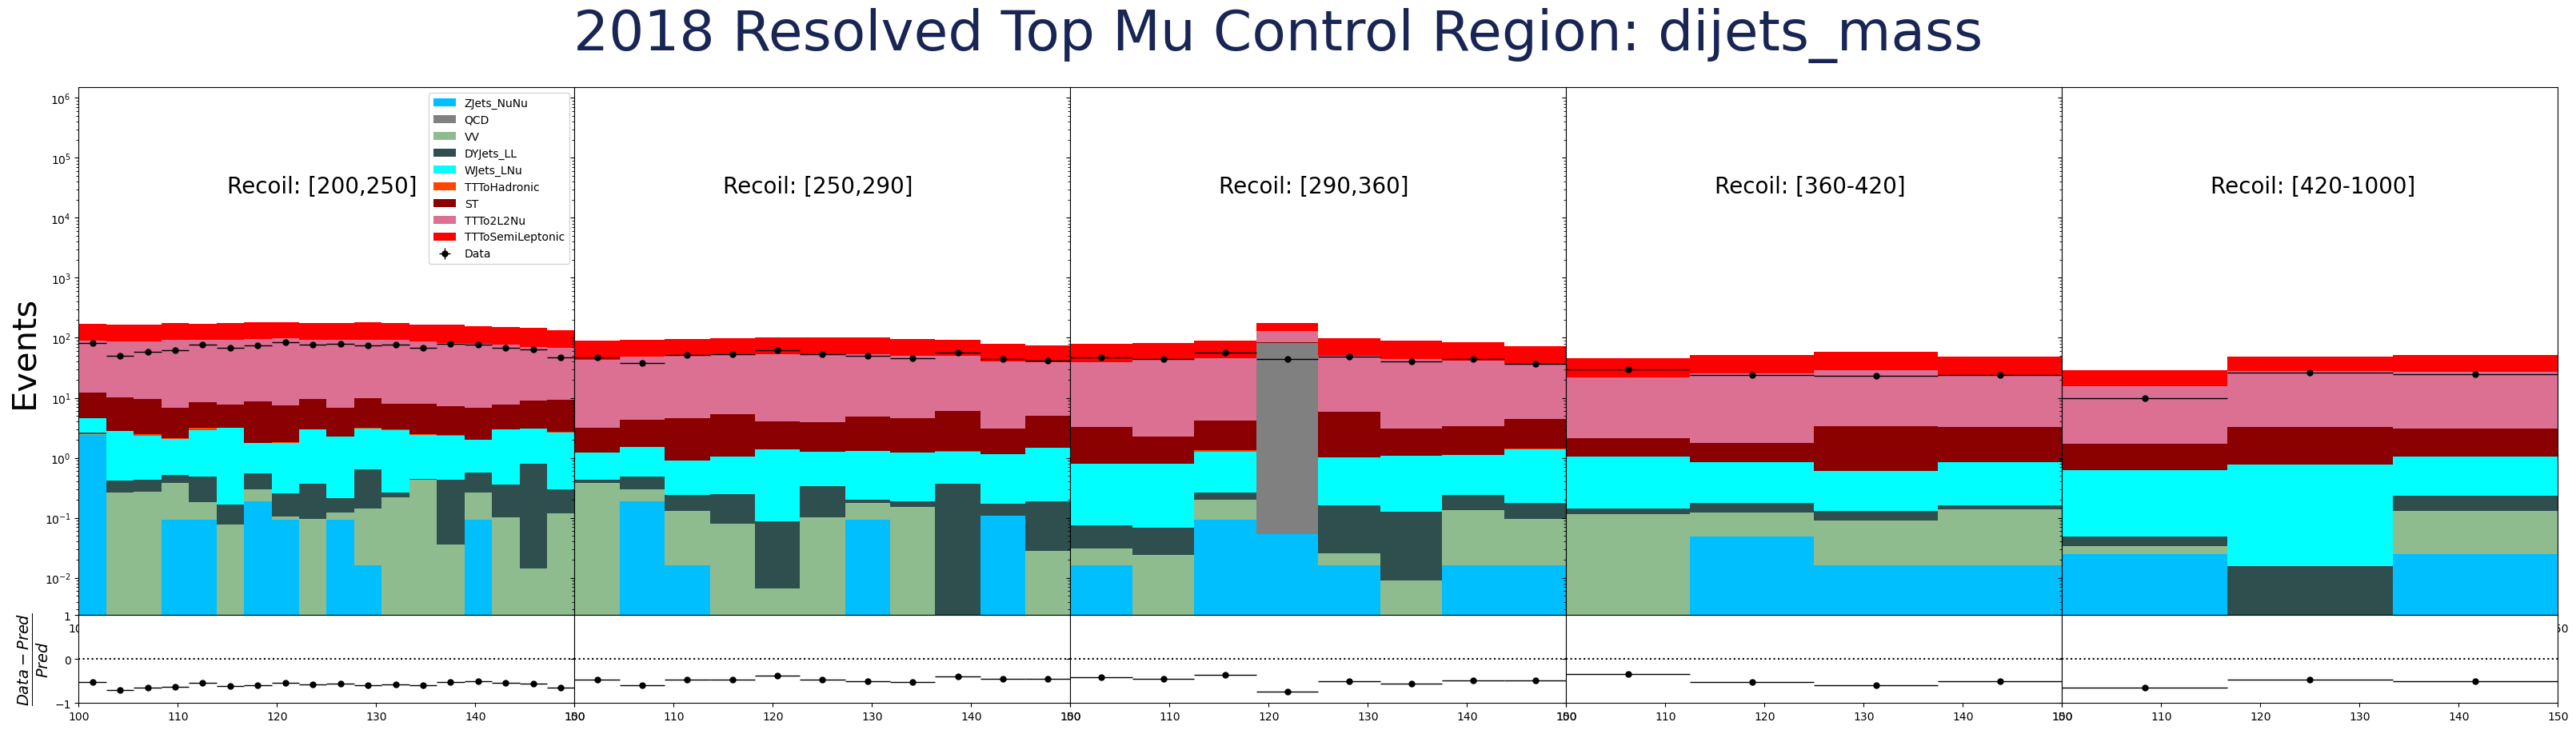

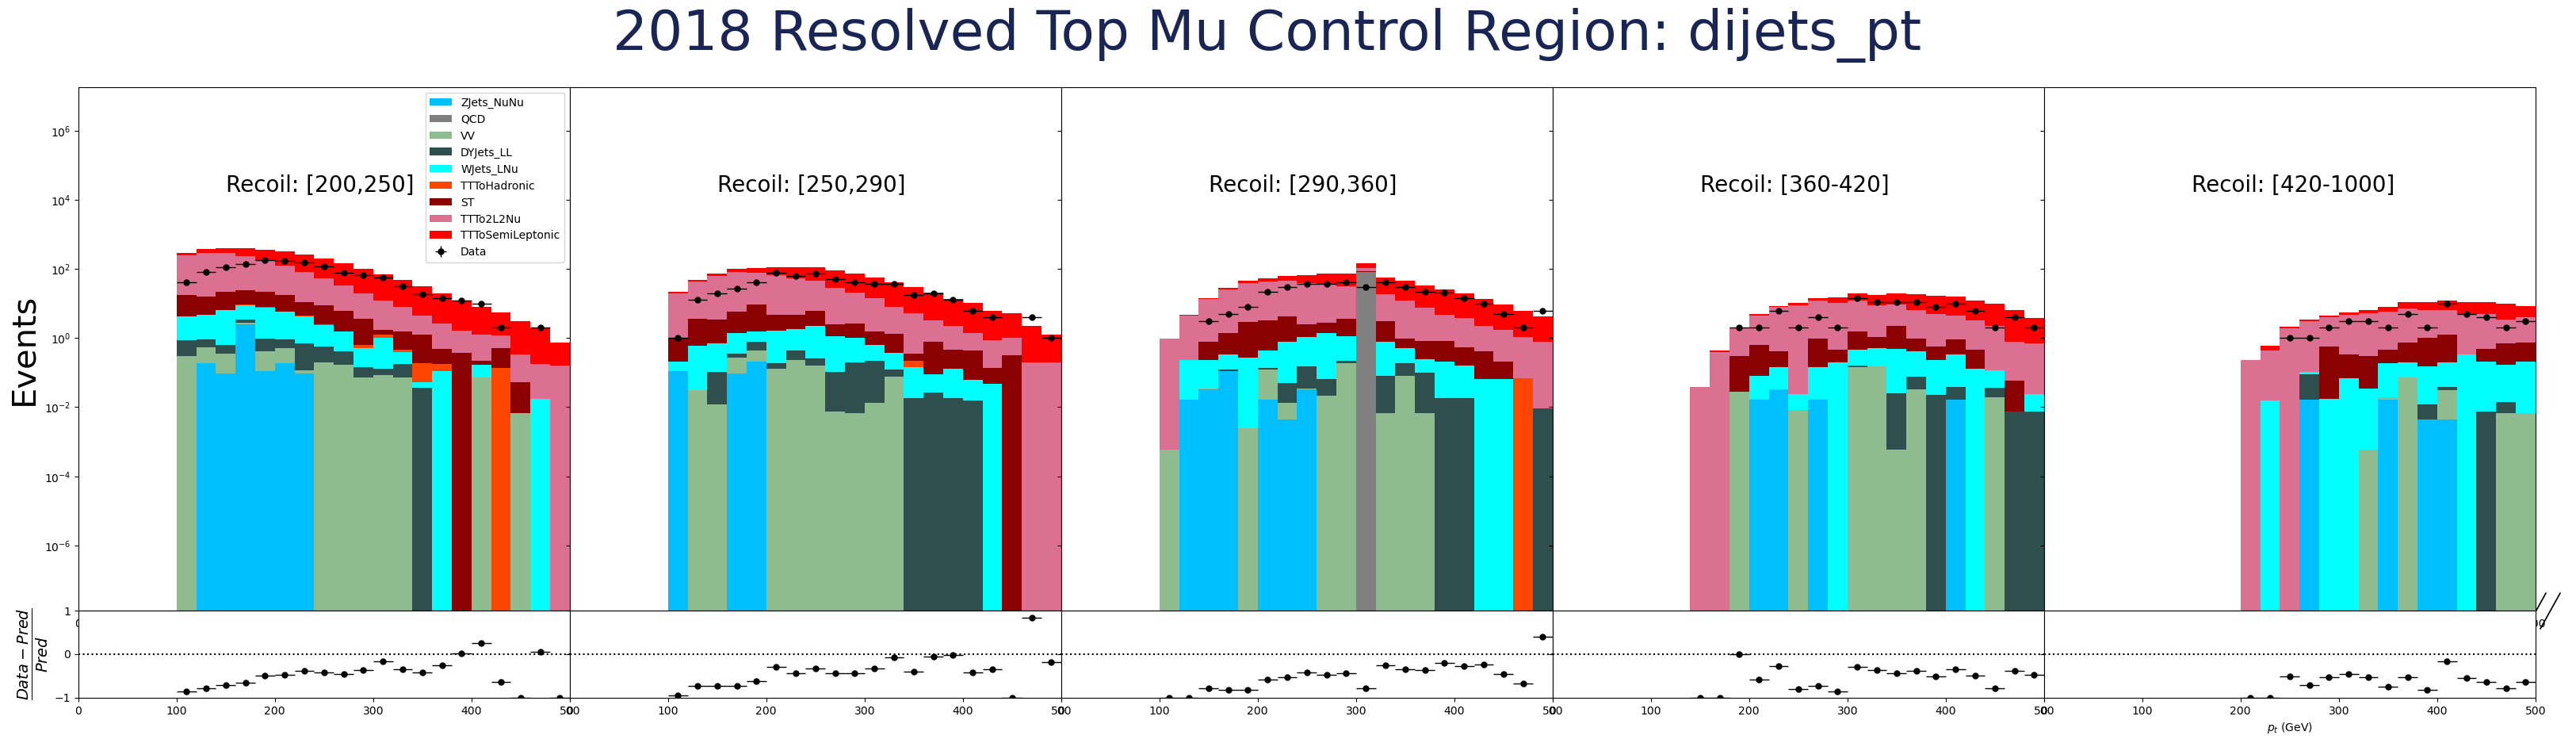

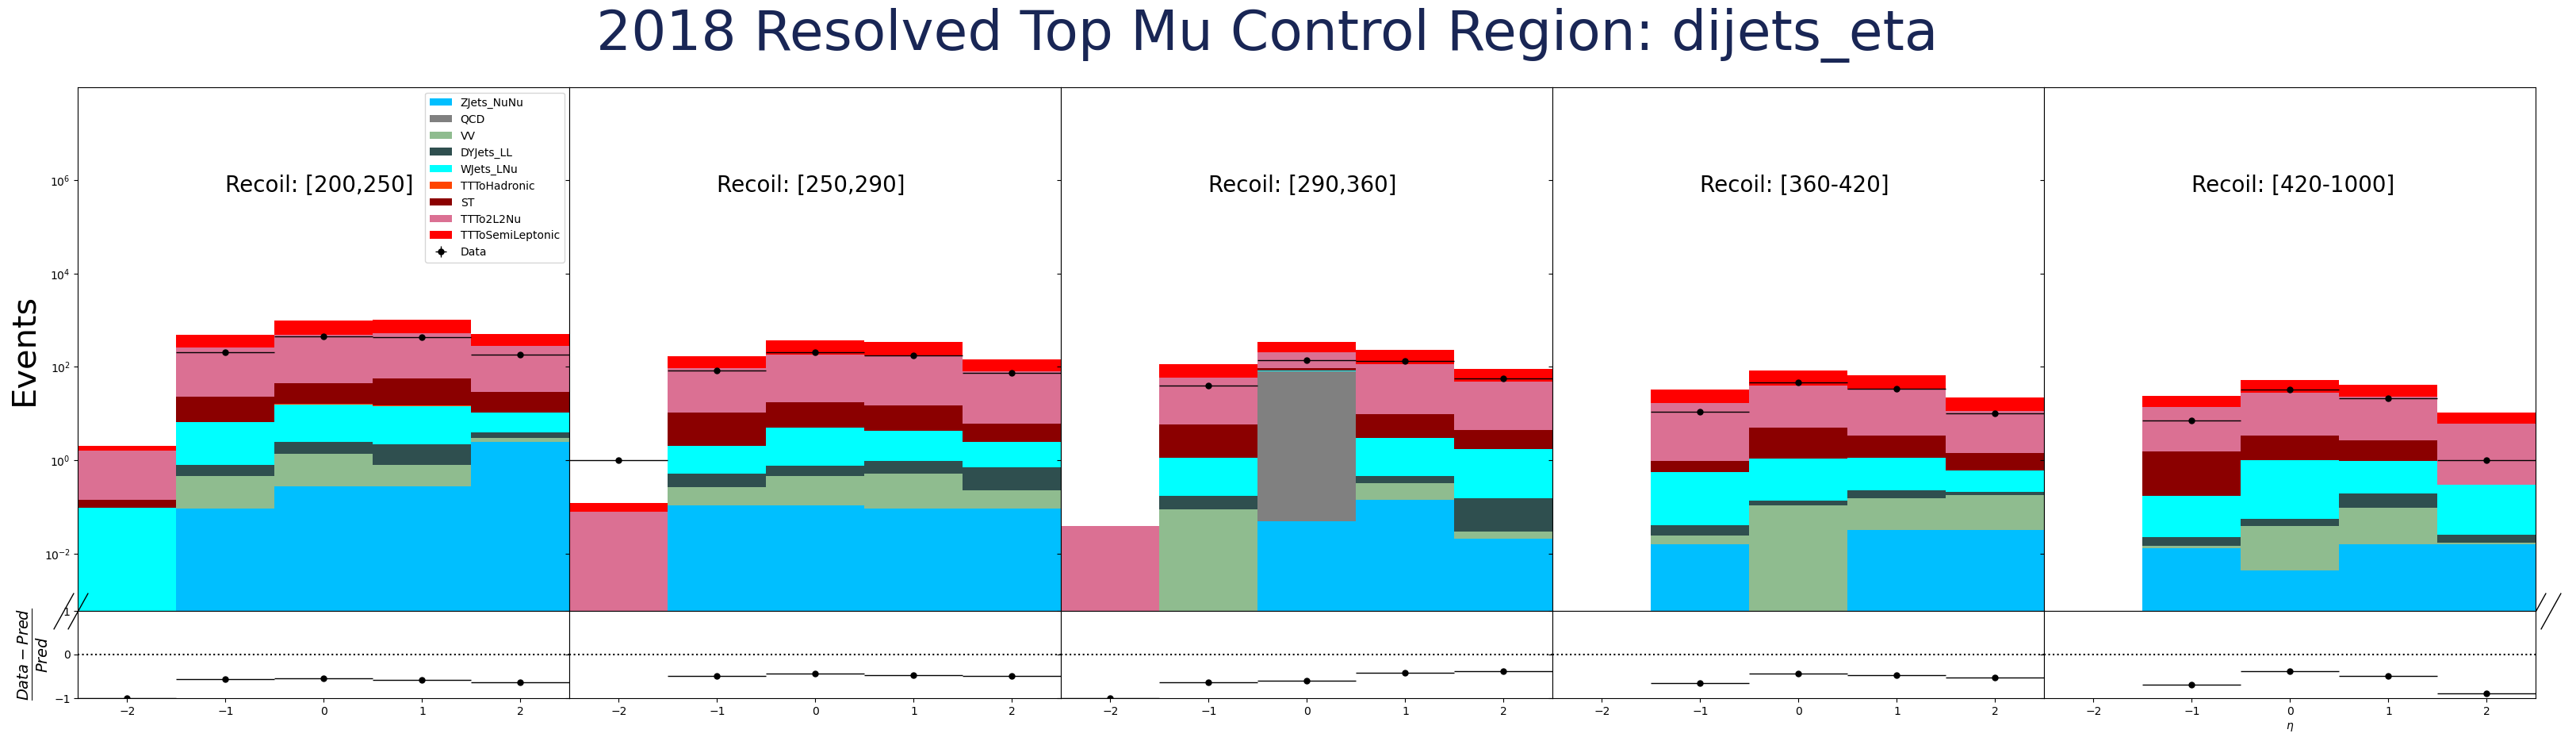

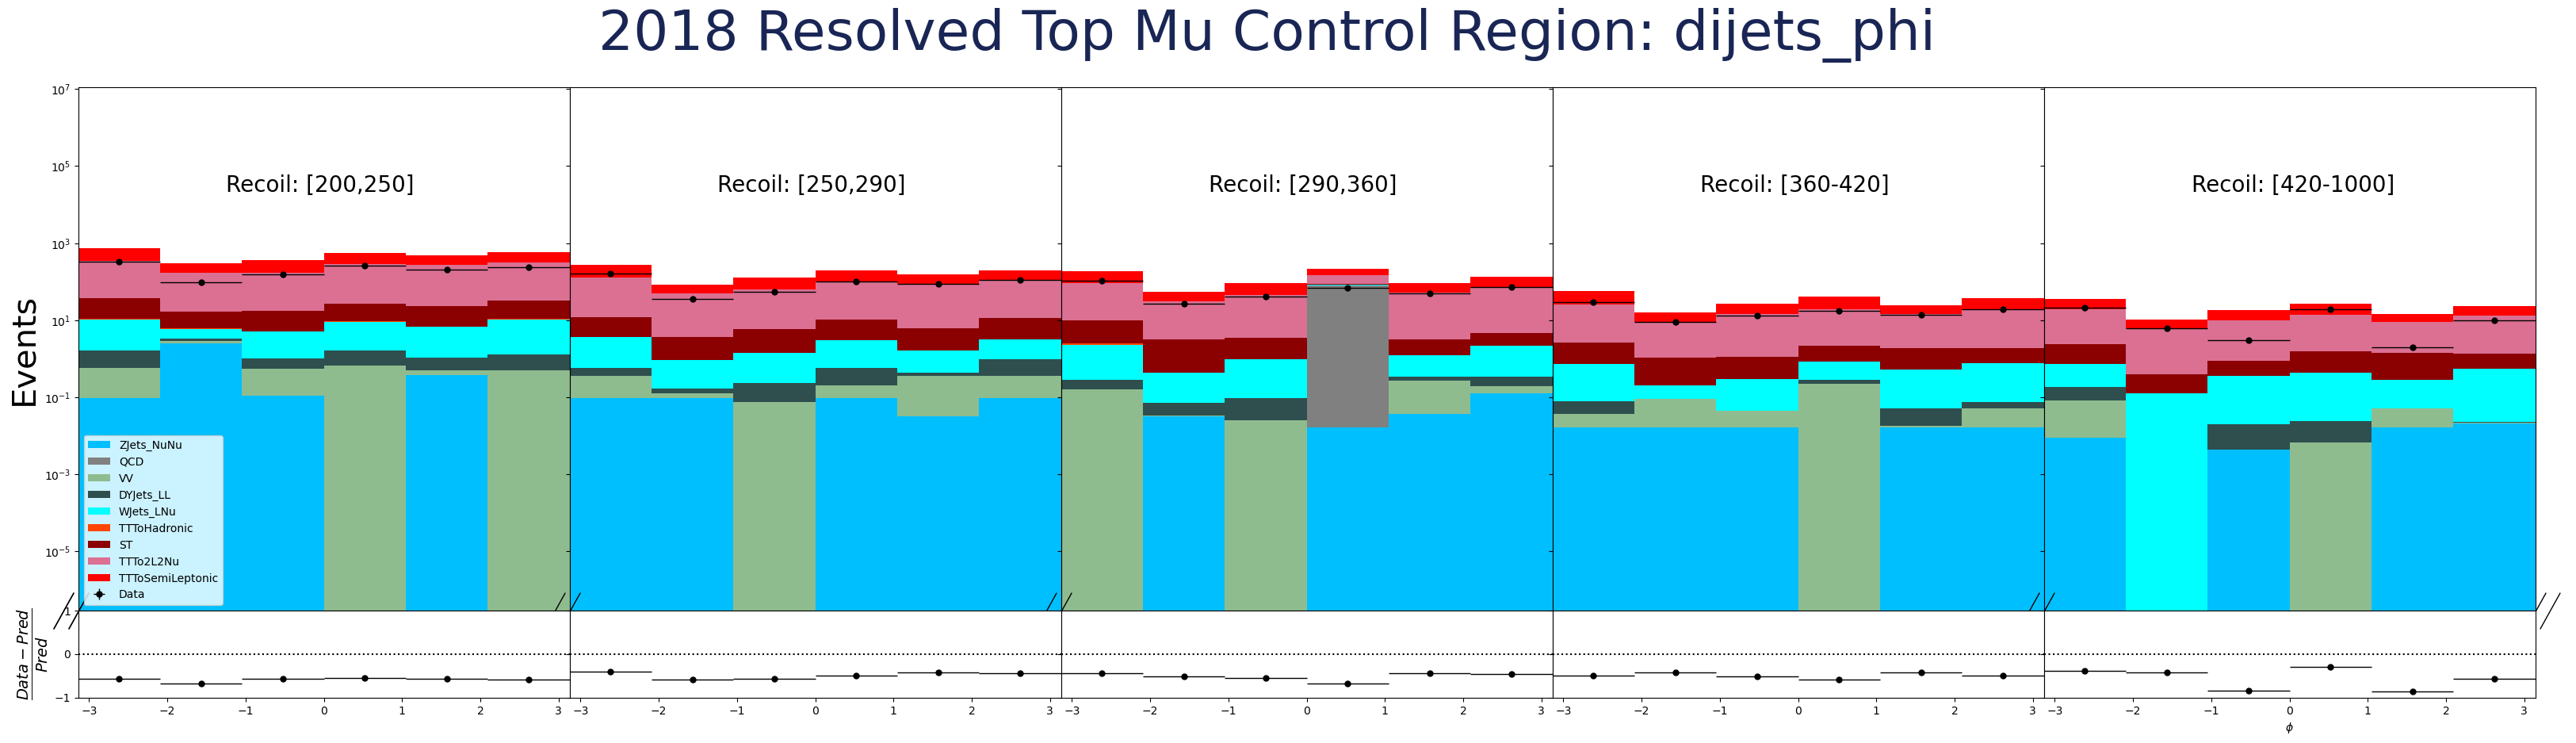

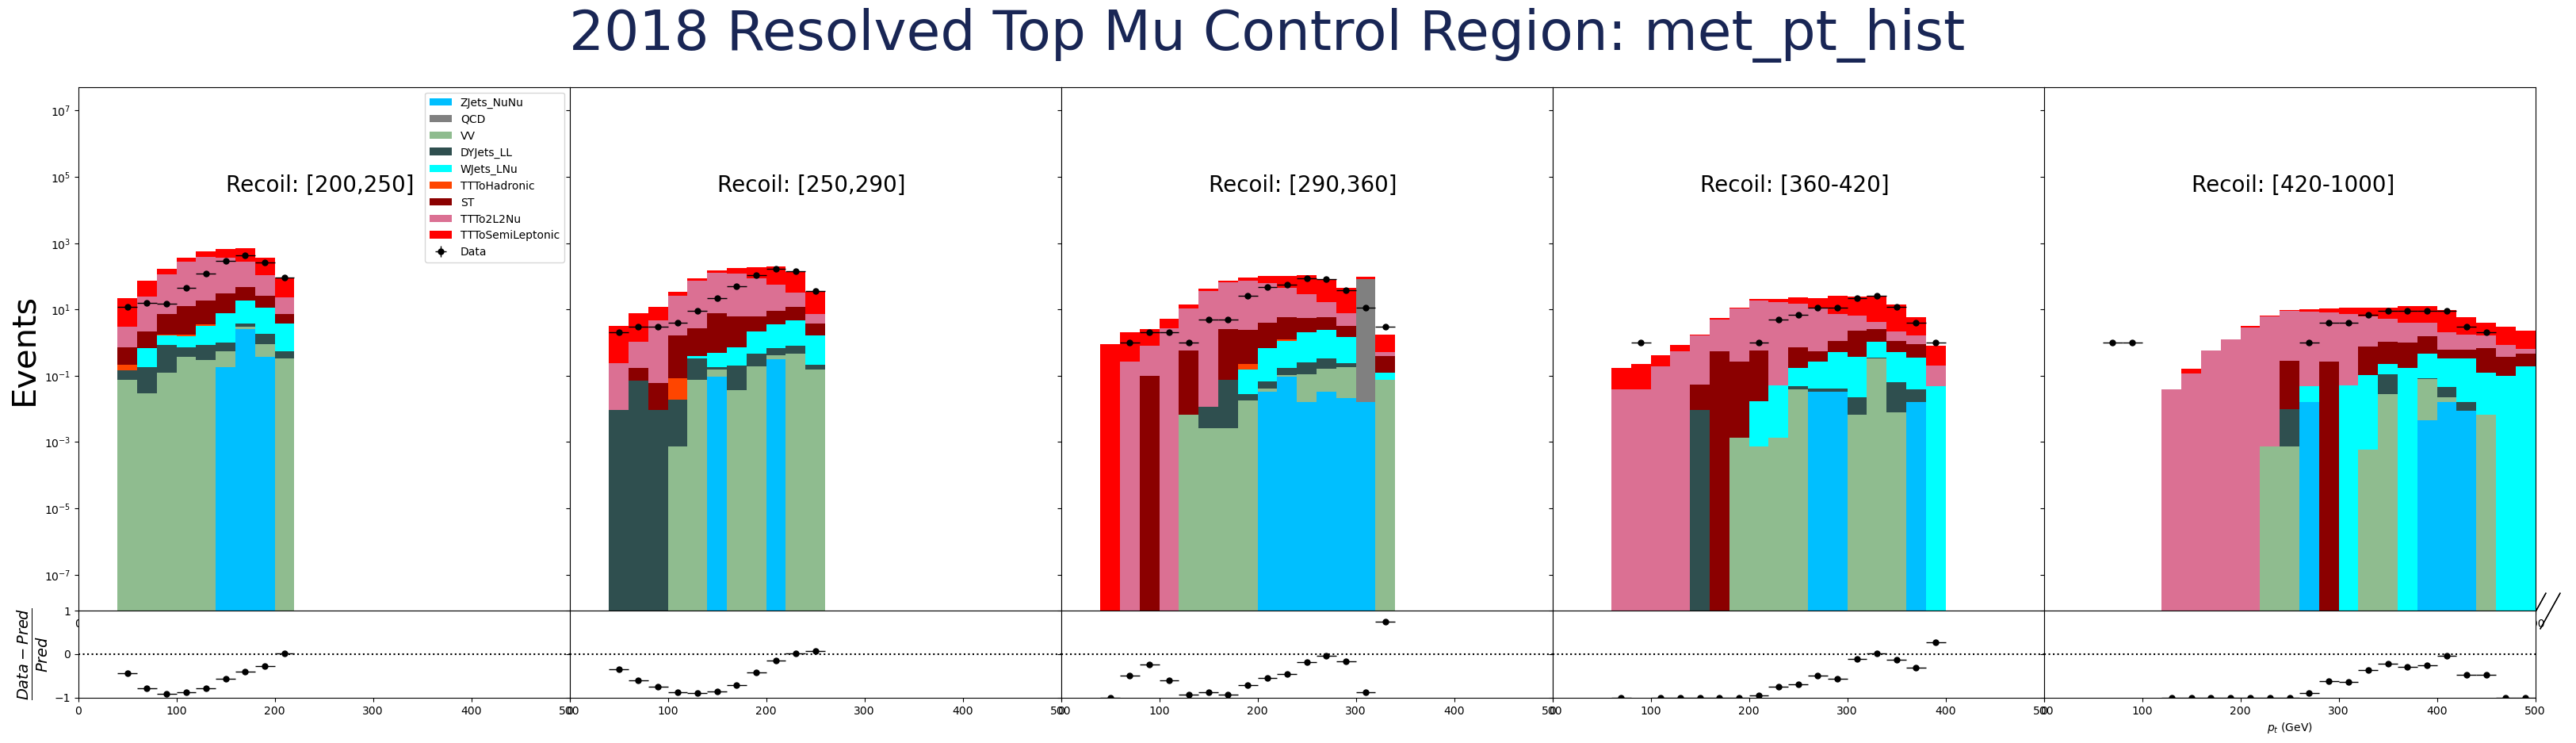

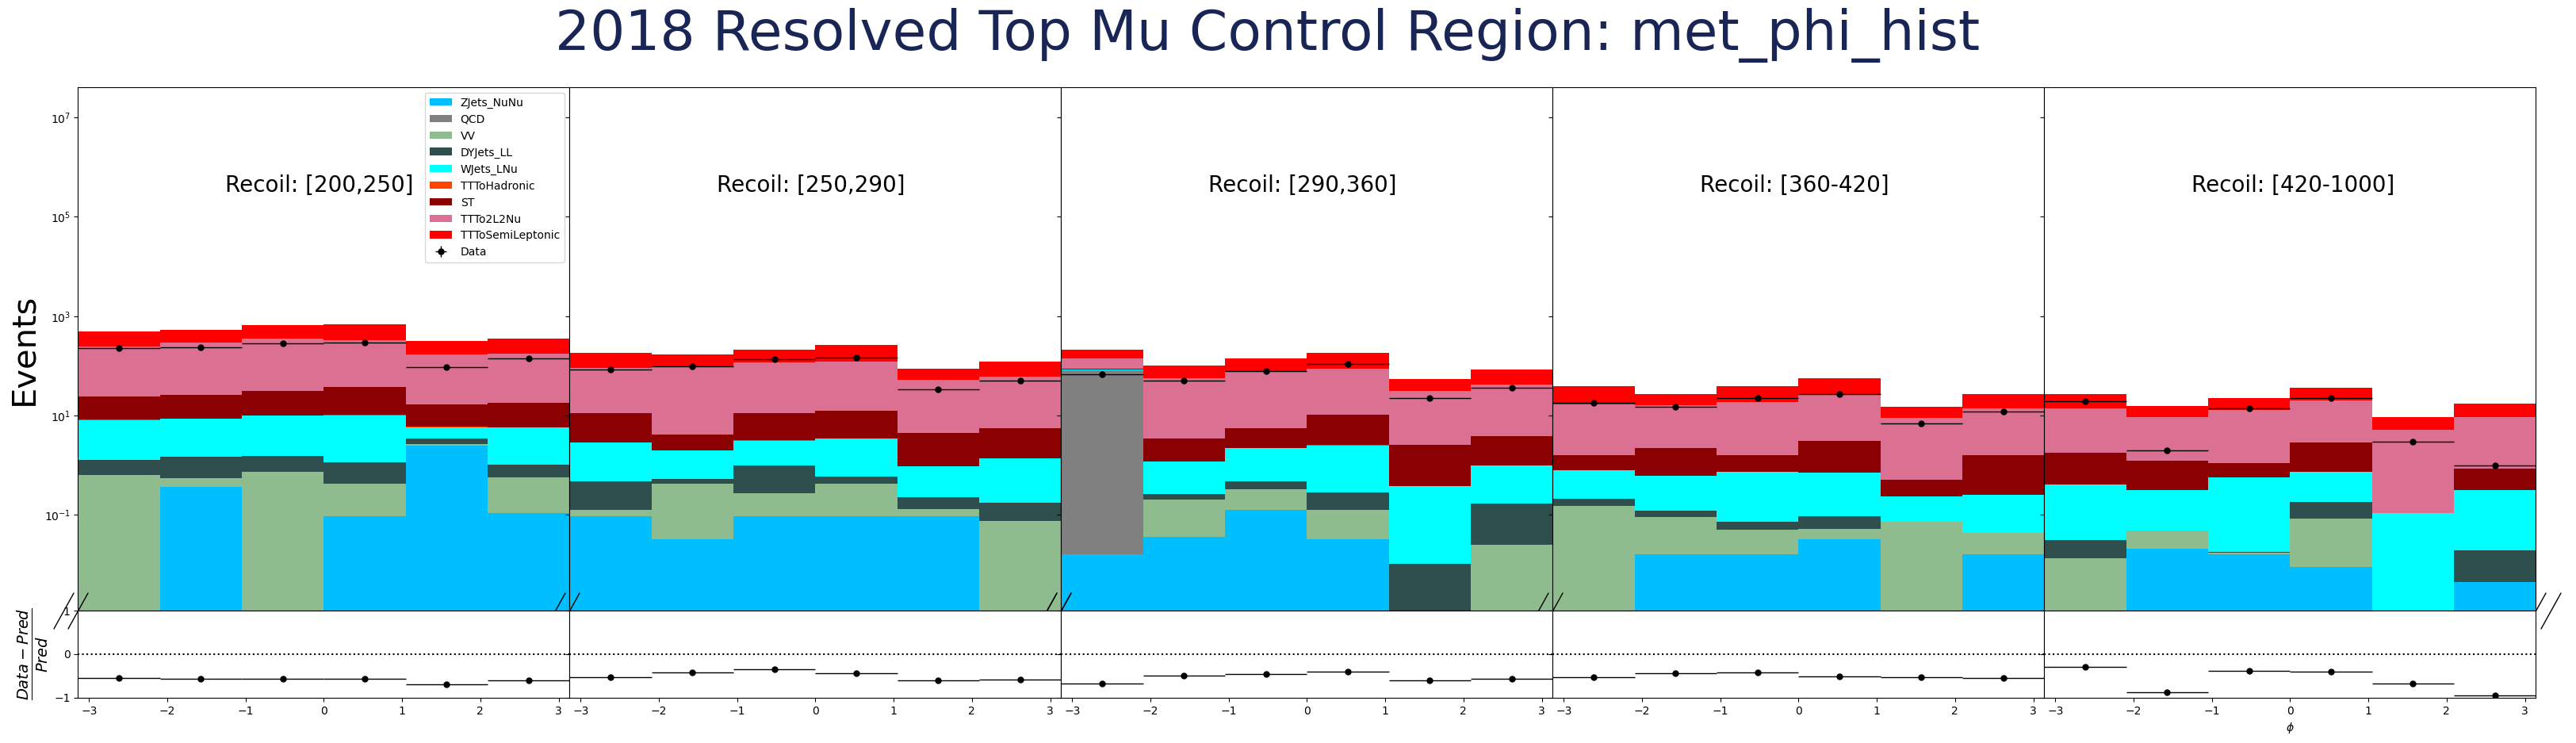

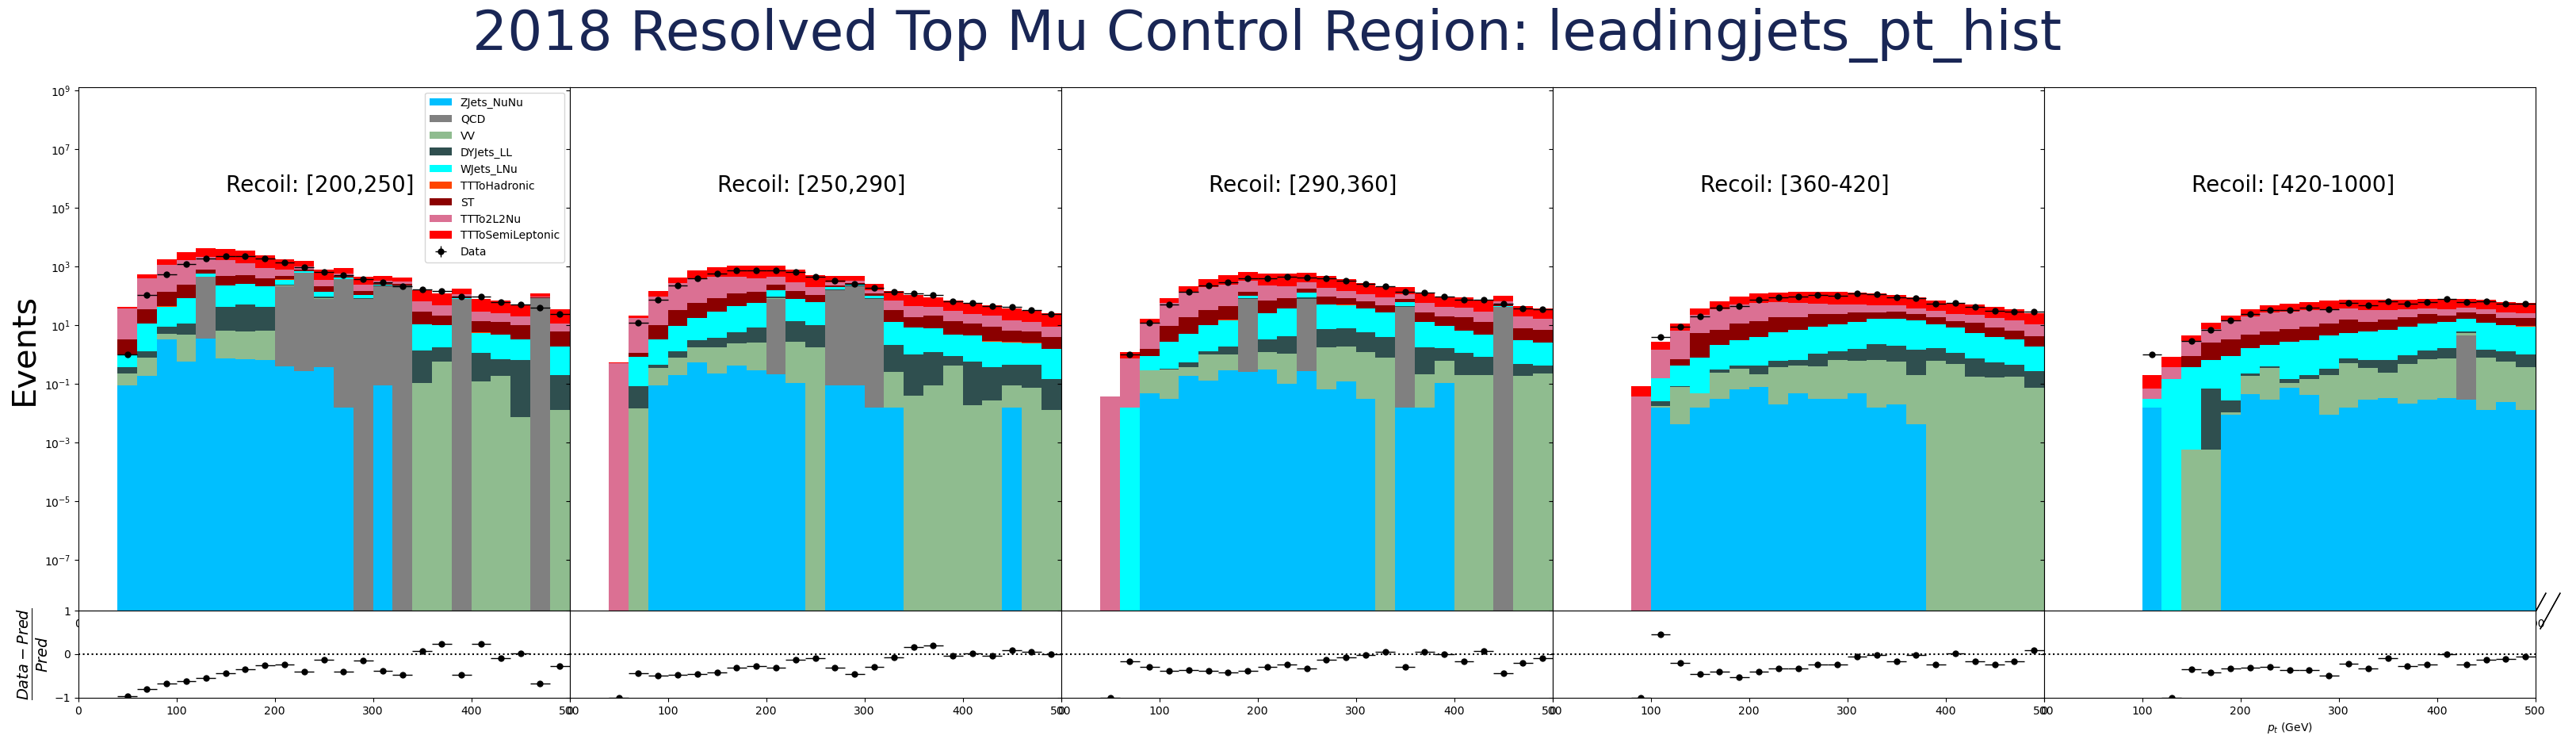

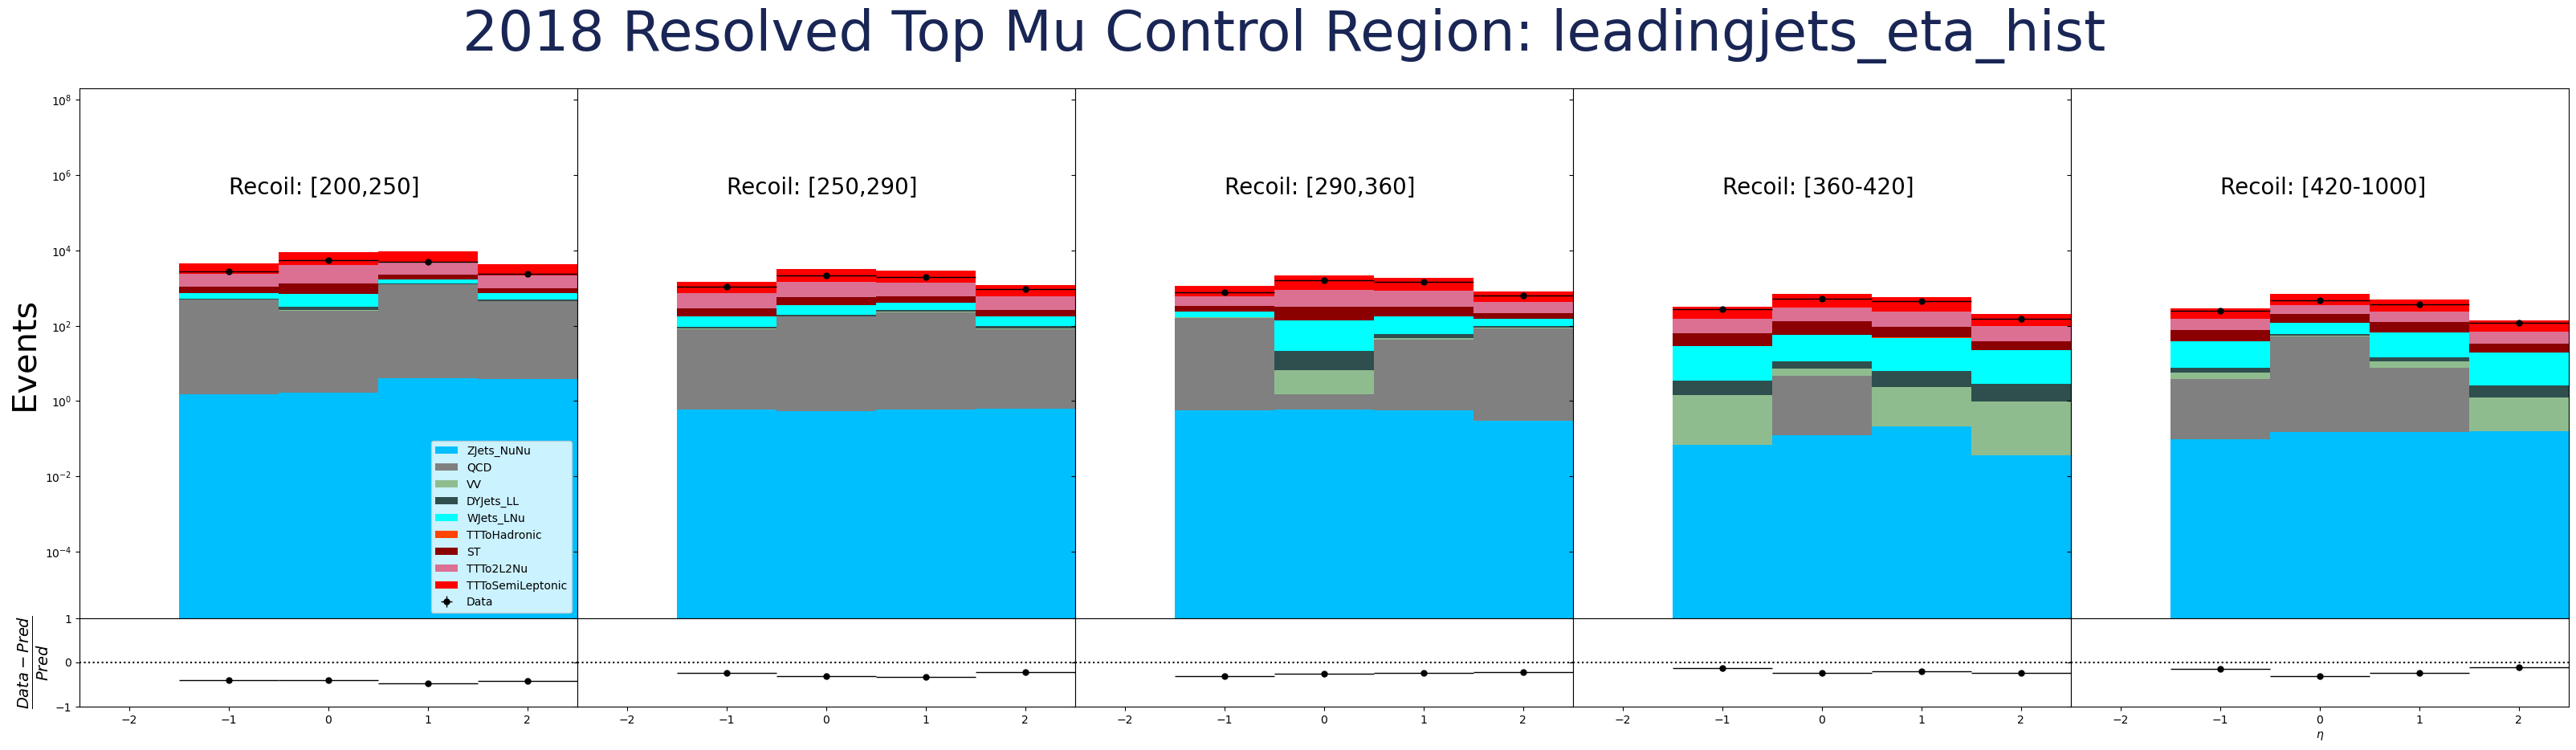

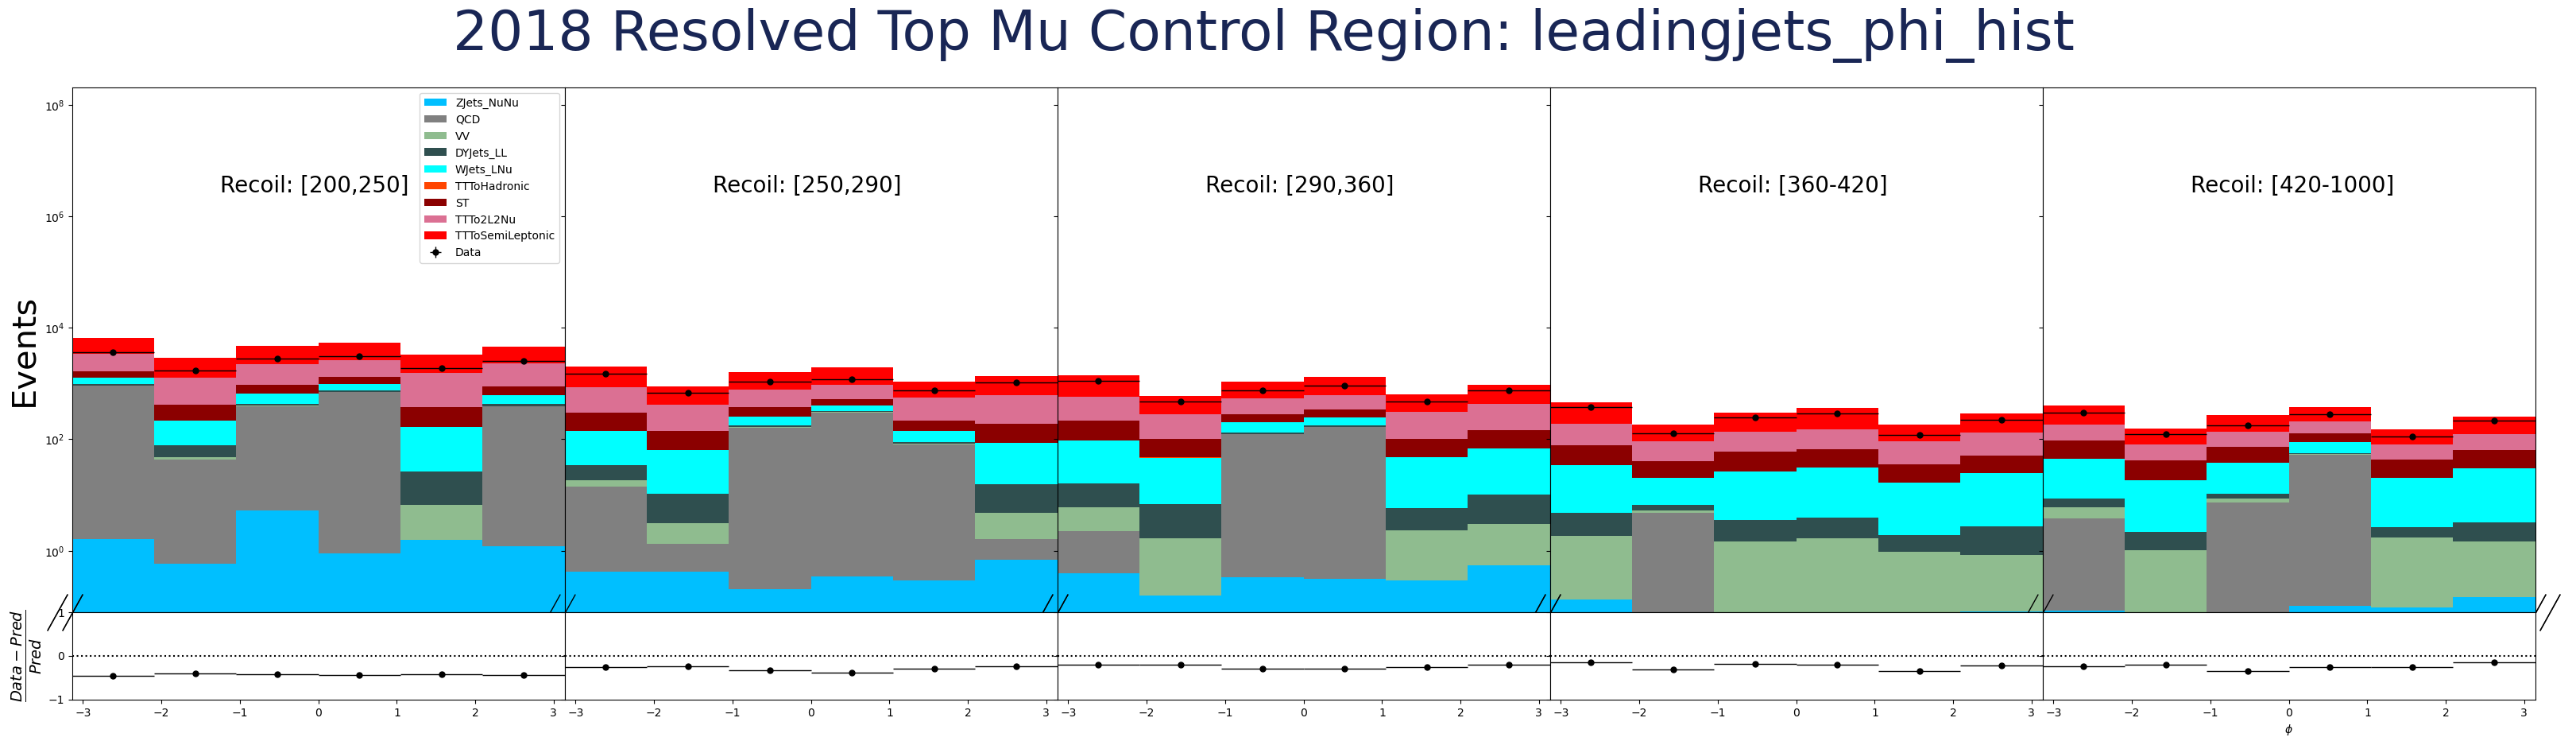

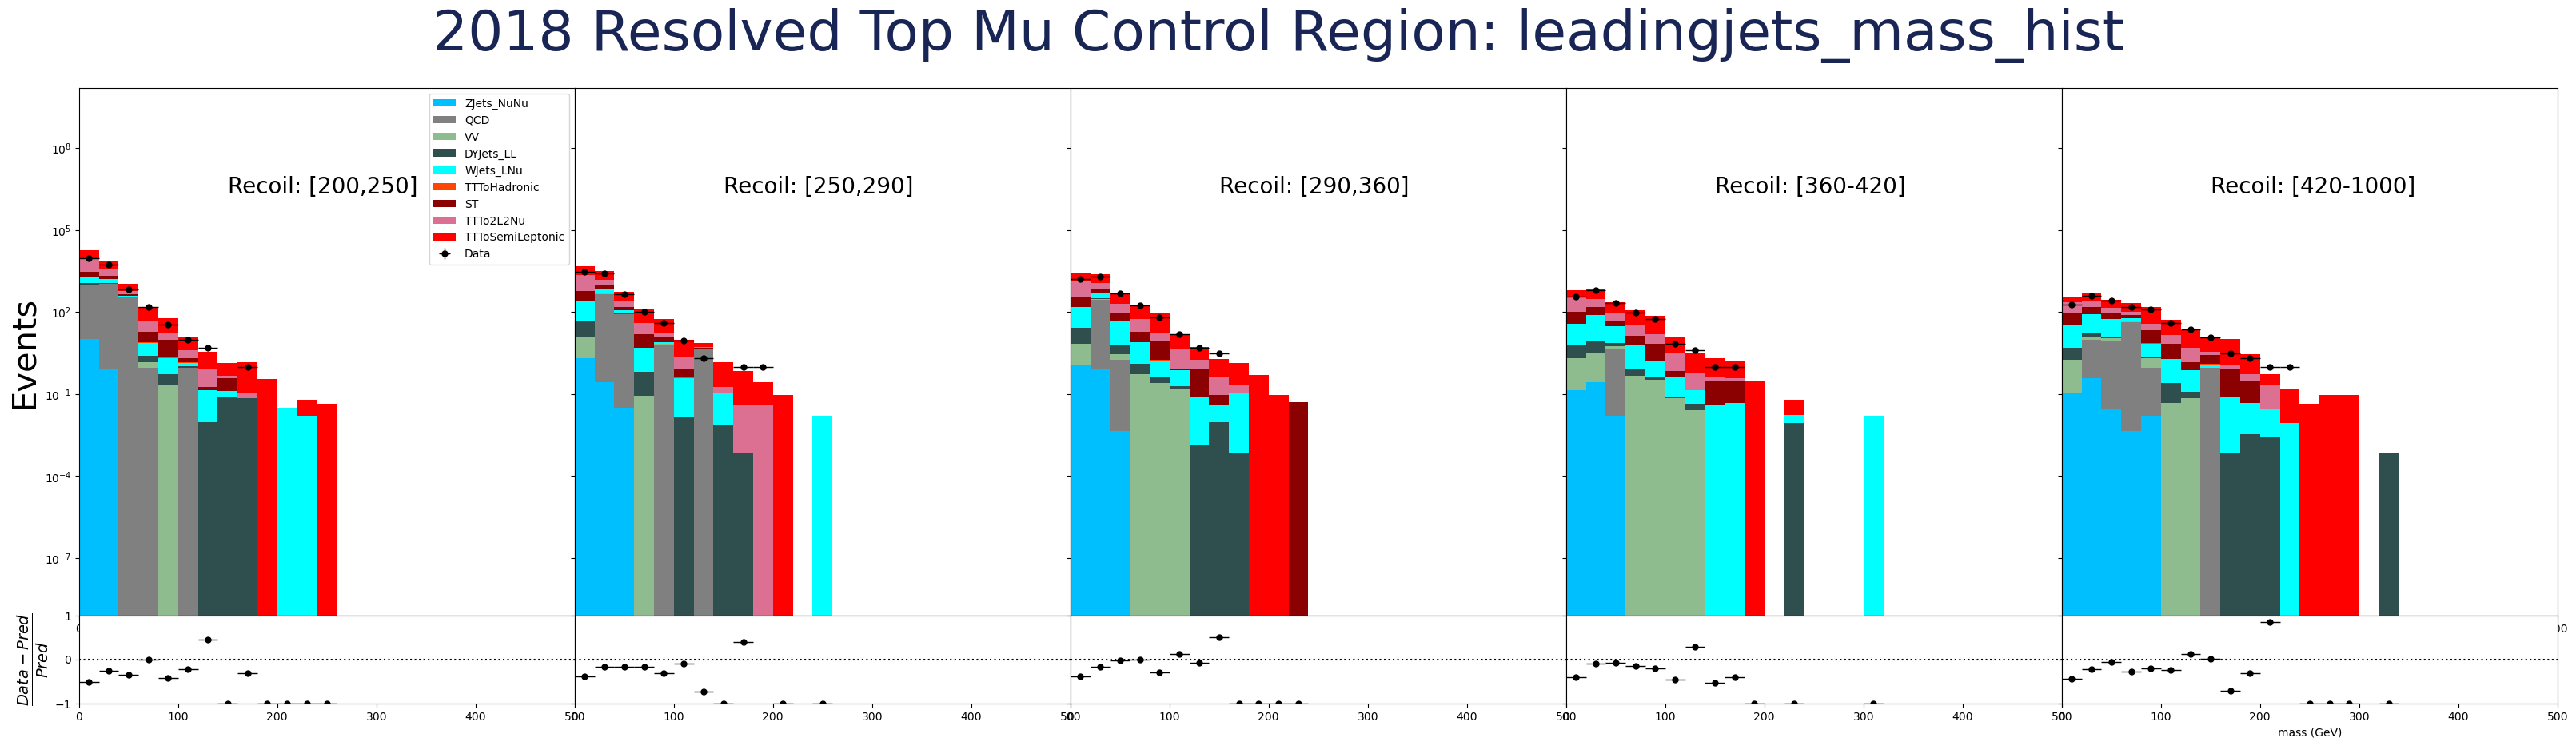

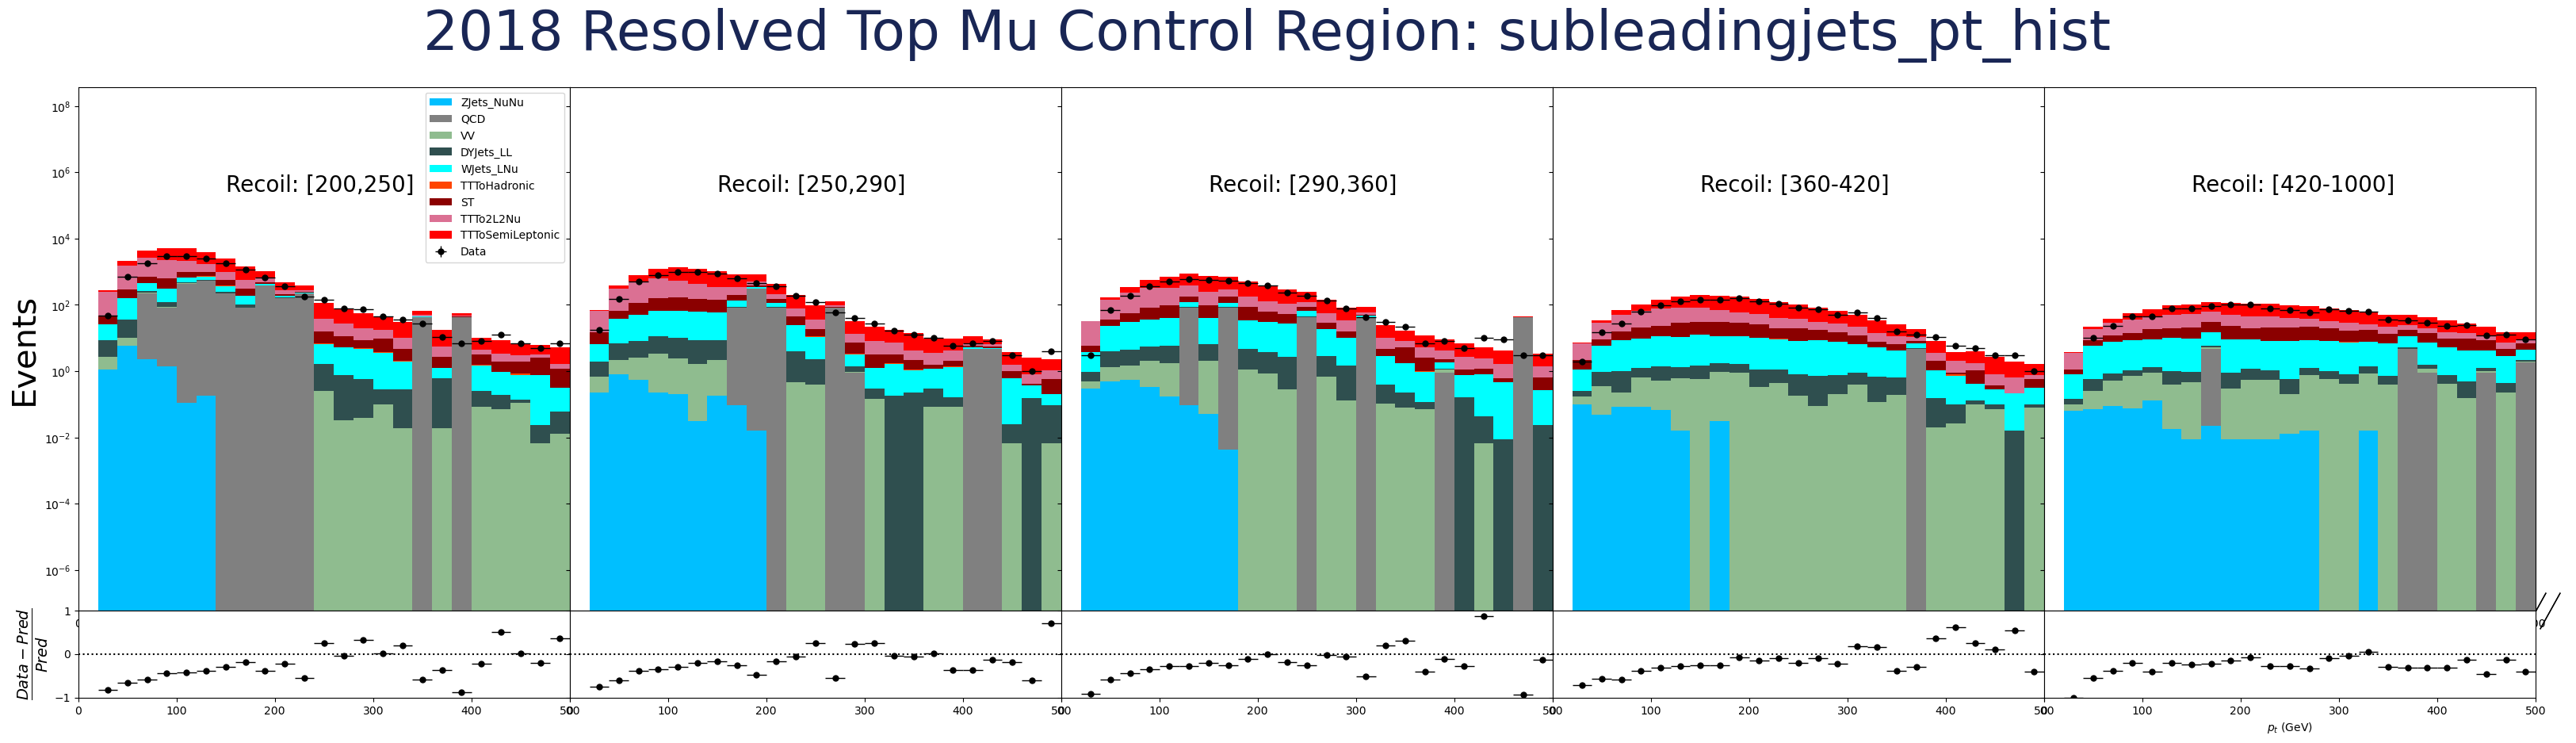

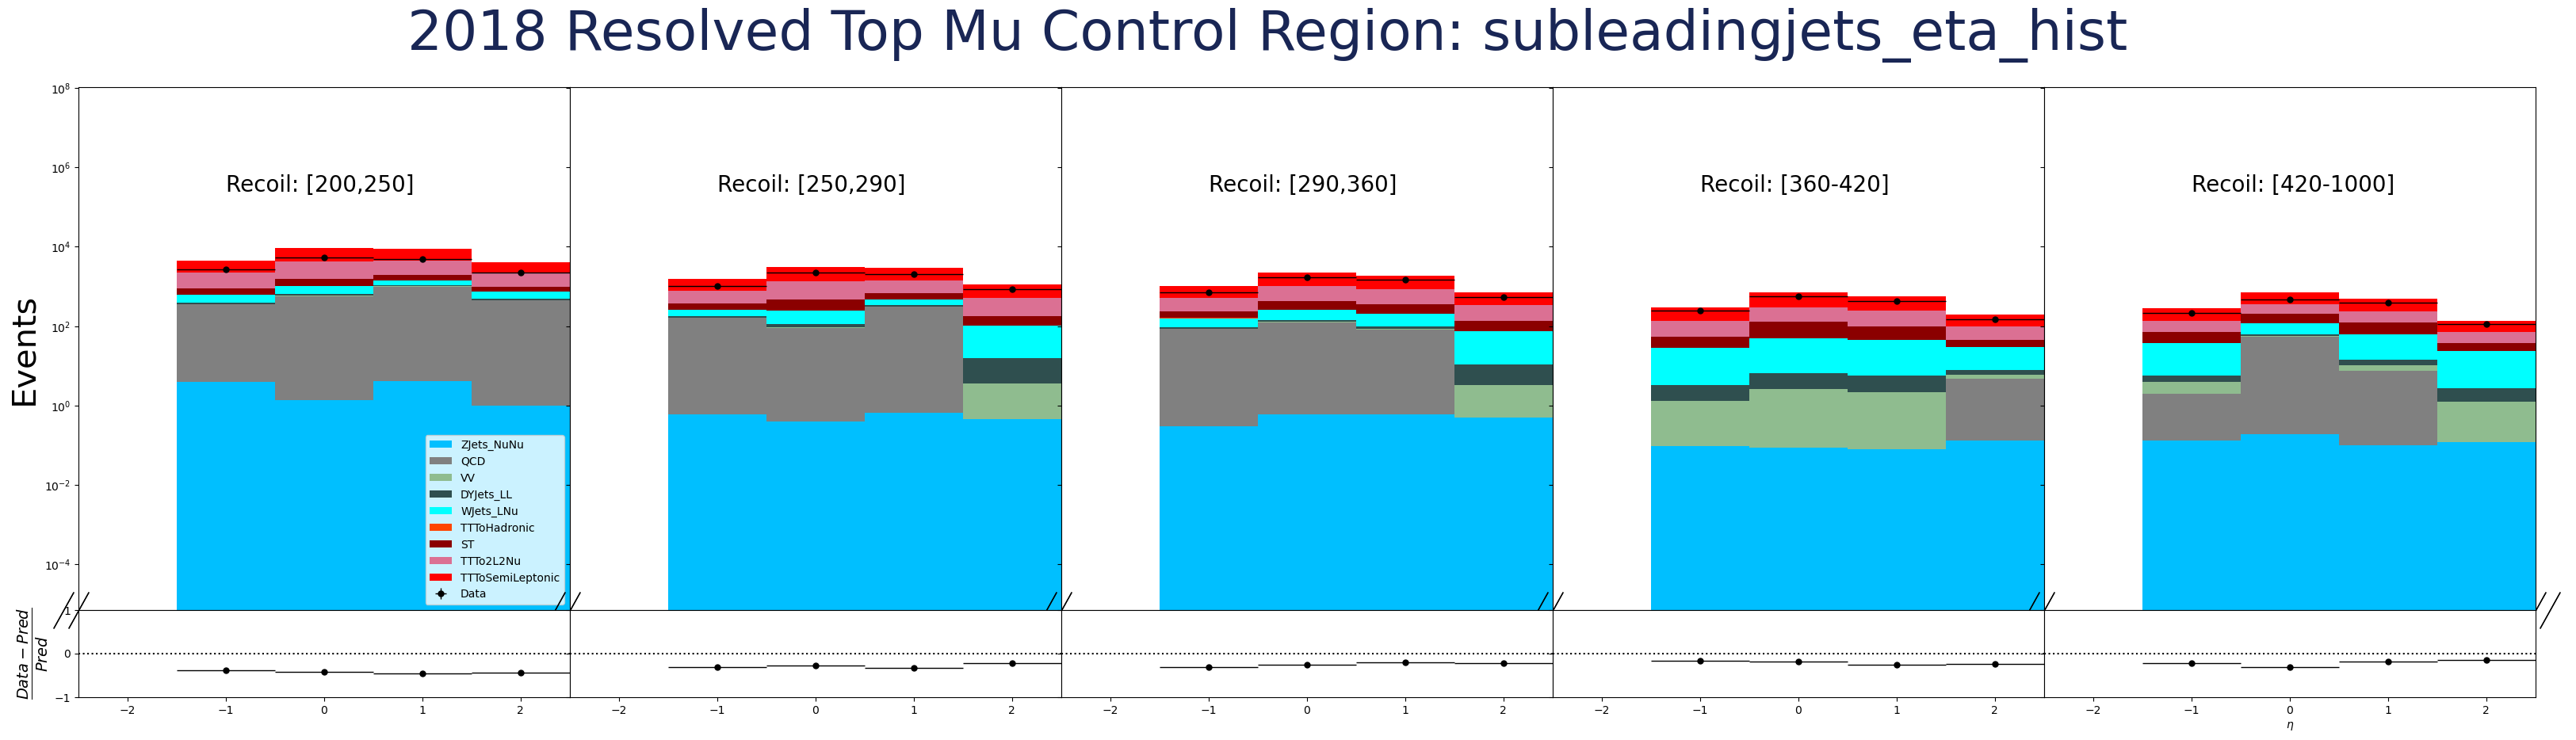

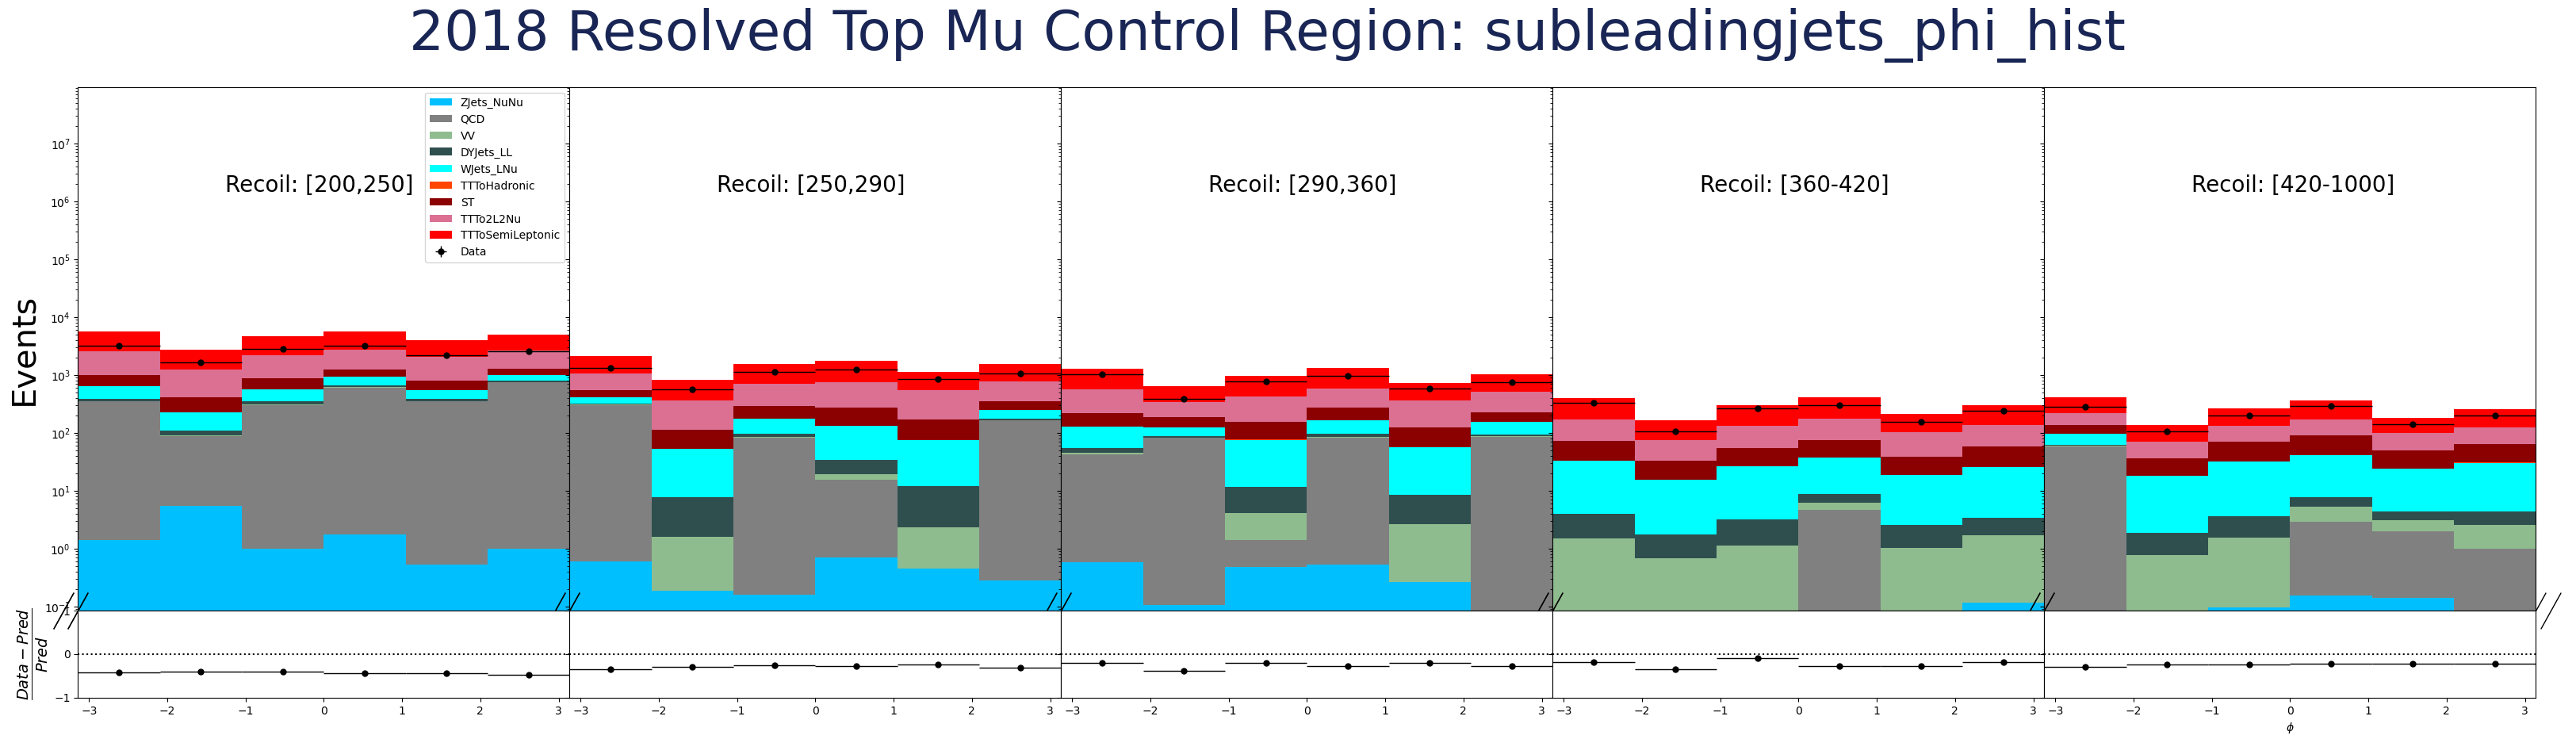

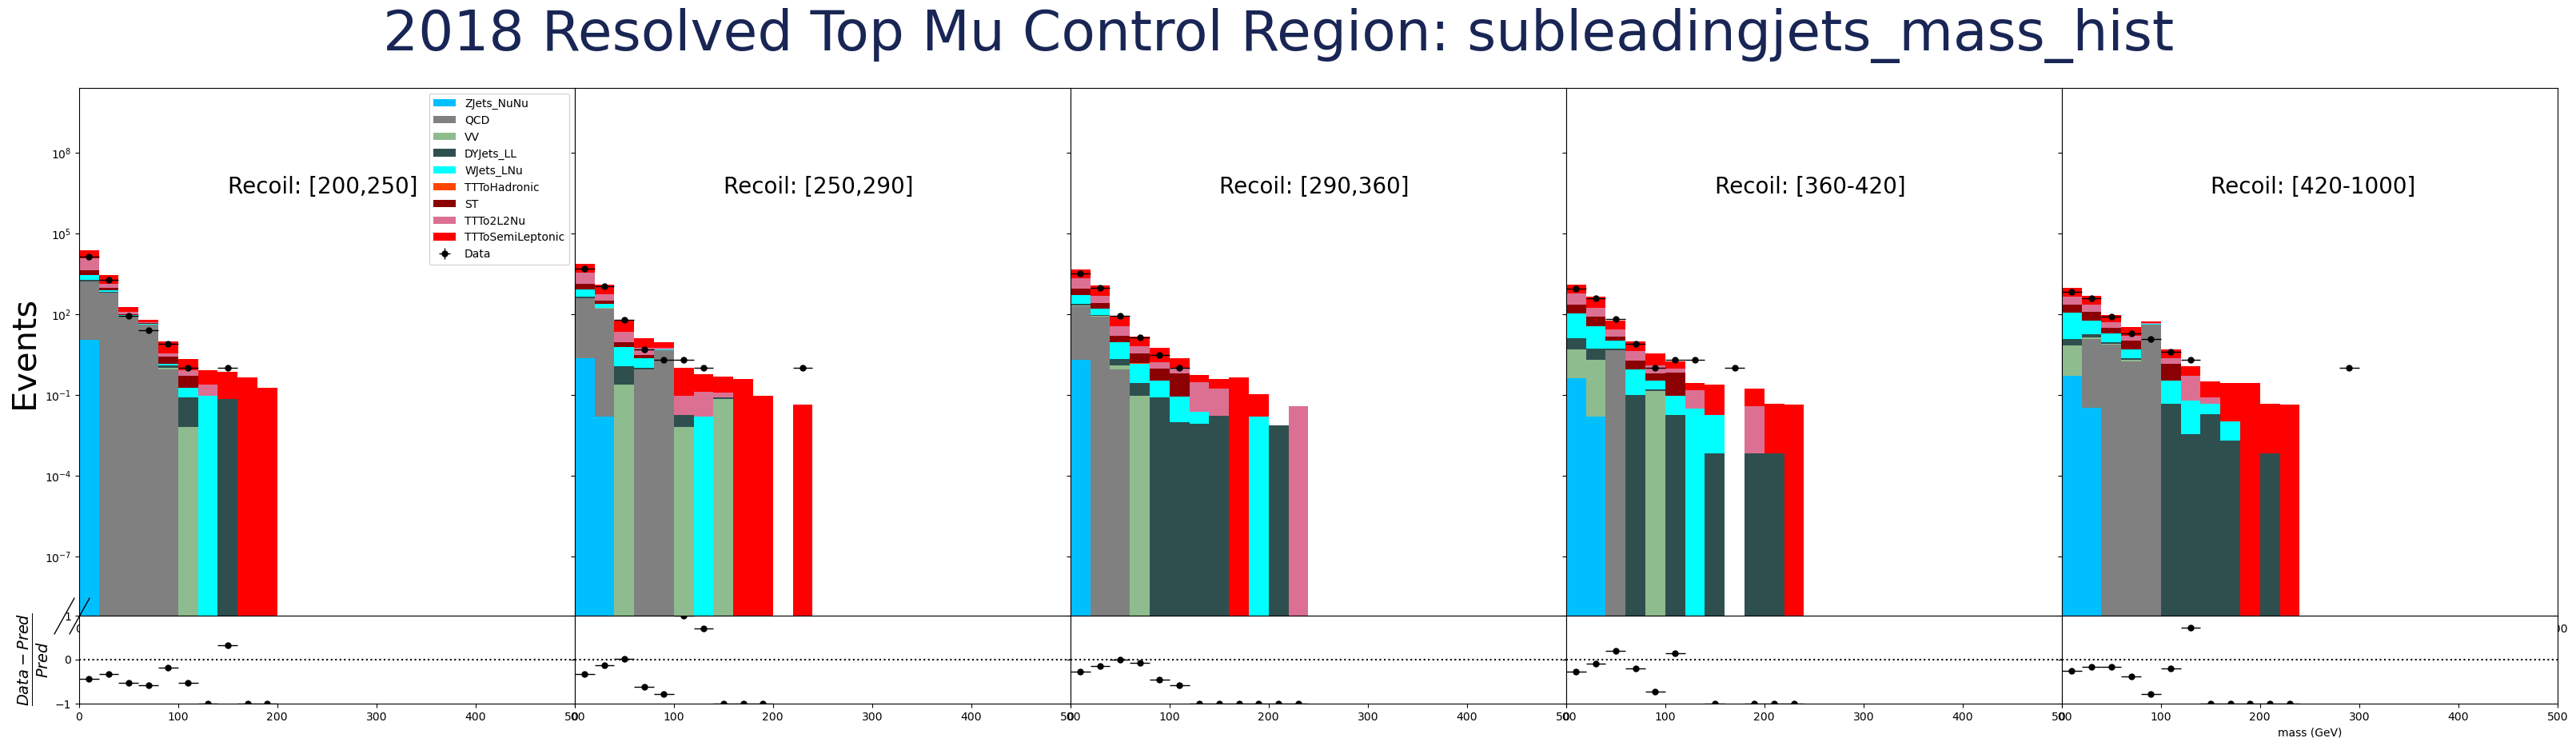

In [35]:
plot_CR(master_dict,property="dijets_mass")
plot_CR(master_dict,property="dijets_pt")
plot_CR(master_dict,property="dijets_eta")
plot_CR(master_dict,property="dijets_phi")
plot_CR(master_dict,property="met_pt_hist")
plot_CR(master_dict,property="met_phi_hist")
plot_CR(master_dict,property="leadingjets_pt_hist")
plot_CR(master_dict,property="leadingjets_eta_hist")
plot_CR(master_dict,property="leadingjets_phi_hist")
plot_CR(master_dict,property="leadingjets_mass_hist")
plot_CR(master_dict,property="subleadingjets_pt_hist")
plot_CR(master_dict,property="subleadingjets_eta_hist")
plot_CR(master_dict,property="subleadingjets_phi_hist")
plot_CR(master_dict,property="subleadingjets_mass_hist")
#plotCRcutflow(master_dict)